In [8]:
cd ..

/home/alberto/PycharmProjects/edc_mo_pdac_val


/home/alberto/anaconda3/envs/edc_mo_pdac_val/lib/python3.11/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


# Multi-omics stratification on PDAC patients

In [9]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import normalized_mutual_info_score
from sklearn.pipeline import make_pipeline
from sklearn.cluster import KMeans
import plotly.express as px
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from umap import UMAP
import optuna
import dill
from torch.utils.data import DataLoader
import pytorch_lightning as pl
from pytorch_lightning.utilities.seed import isolate_rng
import torch
import seaborn as sns
from lifelines.statistics import multivariate_logrank_test
from lifelines import KaplanMeierFitter, CoxPHFitter
import matplotlib.pyplot as plt
from lifelines.plotting import add_at_risk_counts
from scipy.stats import chi2_contingency, kruskal, wilcoxon

from src import settings
from src.utils import MultiViewDataset, transform_full_dataset
from src.optimization import Optimization

In [10]:
data_folder = "data"
processed_data_folder = "processed"
processed_data_path = os.path.join(data_folder, processed_data_folder)

## Load dataset

In [11]:
clinical_data = pd.read_csv(settings.clinical_data_path, index_col= 0)
print("clinical_data.shape", clinical_data.shape)
clinical_data.head()

clinical_data.shape (57, 336)


,clinical_Age_at_Diagnosis,clinical_Height,clinical_Weight,clinical_Chemotherapy_Binary,clinical_BMI,clinical_TNM_Mixed_Substage,clinical_Sex_ord,clinical_Site_-_Primary_ICD-O-3_ord,clinical_Histology_Behavior_ICD-O-3_ord,clinical_TNM_Mixed_Stage_ord,clinical_Grade_Mixed_ord,clinical_Surgical_Margins_Summary_ord,clinical_Chemotherapy_Summary_ord,clinical_Radiation_Summary_ord,clinical_Perineural_Invasion_ord,clinical_Lymphovascular_Invasion_ord,clinical_Family_history_1st_any_cancer_ord,clinical_Family_history_2nd_any_cancer_ord,clinical_Family_history_1st_this_cancer_ord,clinical_Family_history_2nd_this_cancer_ord,clinical_Patient_History_of_Cancer_Seq_1_ord,clinical_Patient_History_of_Cancer_Seq_2_ord,clinical_Patient_History_Alcohol_ord,clinical_Patient_History_Tobacco_ord,clinical_merged_ethnicity_ord,clinical_secondary_diagnosis_onehot__0,clinical_secondary_diagnosis_onehot__a4159,clinical_secondary_diagnosis_onehot__b002,clinical_secondary_diagnosis_onehot__b029,clinical_secondary_diagnosis_onehot__e1142,clinical_secondary_diagnosis_onehot__e119,clinical_secondary_diagnosis_onehot__e43,clinical_secondary_diagnosis_onehot__e440,clinical_secondary_diagnosis_onehot__e46,clinical_secondary_diagnosis_onehot__e669,clinical_secondary_diagnosis_onehot__e785,clinical_secondary_diagnosis_onehot__e870,clinical_secondary_diagnosis_onehot__e871,clinical_secondary_diagnosis_onehot__e8809,clinical_secondary_diagnosis_onehot__g92,...,clinical_secondary_diagnosis_onehot__z87442,clinical_secondary_diagnosis_onehot__z951,clinical_secondary_diagnosis_onehot__e109,clinical_secondary_diagnosis_onehot__e876.2,clinical_secondary_diagnosis_onehot__g8918.5,clinical_secondary_diagnosis_onehot__i10.7,clinical_secondary_diagnosis_onehot__i129.1,clinical_secondary_diagnosis_onehot__i2510.4,clinical_secondary_diagnosis_onehot__i493,clinical_secondary_diagnosis_onehot__k219.4,clinical_secondary_diagnosis_onehot__k5900.2,clinical_secondary_diagnosis_onehot__k760,clinical_secondary_diagnosis_onehot__m170,clinical_secondary_diagnosis_onehot__n183,clinical_secondary_diagnosis_onehot__n2581,clinical_secondary_diagnosis_onehot__nan.8,clinical_secondary_diagnosis_onehot__r918,clinical_secondary_diagnosis_onehot__z87891.3,clinical_secondary_diagnosis_onehot__z923,clinical_secondary_diagnosis_onehot__b952.1,clinical_secondary_diagnosis_onehot__e669.3,clinical_secondary_diagnosis_onehot__e780,clinical_secondary_diagnosis_onehot__e8339,clinical_secondary_diagnosis_onehot__g4730,clinical_secondary_diagnosis_onehot__g4733.1,clinical_secondary_diagnosis_onehot__g8918.6,clinical_secondary_diagnosis_onehot__i129.2,clinical_secondary_diagnosis_onehot__j9811.4,clinical_secondary_diagnosis_onehot__k5790,clinical_secondary_diagnosis_onehot__m109,clinical_secondary_diagnosis_onehot__m8580,clinical_secondary_diagnosis_onehot__n183.1,clinical_secondary_diagnosis_onehot__nan.9,clinical_secondary_diagnosis_onehot__z85828,clinical_secondary_diagnosis_onehot__z87442.1,label_deceased,label_days_to_death,clusters,preds_hc,preds_kmeans
GI-19-025,92,70,168,0,24.102857,1,0,0,85003,0,1,0,0,0,0,0,2,3,2,1,1,2,0,2,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2190,0,0,0
GI-17-537,78,64,119,1,20.424072,3,1,3,85003,1,2,0,3,1,1,1,2,3,2,1,1,2,2,2,13,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,2190,1,1,2
GI-19-002,82,71,258,1,35.979766,3,0,4,85003,1,0,0,2,0,1,0,2,3,2,1,1,2,1,2,13,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,2190,0,0,0
GI-16-575,66,67,147,1,23.020940,3,0,0,85003,1,1,0,3,1,1,1,2,3,2,1,1,2,1,2,13,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,2190,0,0,0
GI-14-974,78,63,131,1,23.203074,3,1,1,85003,1,1,0,2,0,1,2,3,4,3,2,1,2,1,1,13,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,474,0,

In [12]:
files = os.listdir(processed_data_path)
files.remove("clinical_data.csv")
files = list(filter(lambda x: os.path.isfile(os.path.join(processed_data_path, x)), files))
file = -1

In [13]:
Xs = [pd.read_csv(os.path.join(processed_data_path, filename), index_col=0) for filename in files]
samples = Xs[0].index

In [14]:
file += 1
filename = files[file]
data = pd.read_csv(os.path.join(processed_data_path, filename), index_col=0)
print(f"{filename}.shape", data.shape)
data.head()

pathology_data.csv.shape (57, 820)


,pathology_NF40_25%,pathology_NF39_0.01,pathology_NF62_75%,pathology_NF58_0.01,pathology_NF46_0.1,pathology_NF16_0.95,pathology_NF59_min,pathology_NF22_std,pathology_NF37_75%,pathology_NF20_0.05,pathology_NF50_0.05,pathology_NF32_max,pathology_NF1_75%,pathology_NF47_0.95,pathology_NF51_75%,pathology_NF35_25%,pathology_NF43_0.99,pathology_NF42_std,pathology_NF51_50%,pathology_NF31_mean,pathology_NF37_max,pathology_NF2_0.1,pathology_NF12_0.01,pathology_NF10_0.05,pathology_NF52_0.95,pathology_NF9_max,pathology_NF3_0.05,pathology_NF8_std,pathology_NF1_mean,pathology_NF11_75%,pathology_NF26_0.95,pathology_NF14_75%,pathology_NF13_0.05,pathology_NF6_max,pathology_NF6_75%,pathology_NF7_0.05,pathology_NF13_0.9,pathology_NF39_50%,pathology_NF34_50%,pathology_NF50_75%,...,pathology_NF1_0.1,pathology_NF27_0.1,pathology_NF30_std,pathology_NF41_0.9,pathology_NF12_mean,pathology_NF40_0.01,pathology_NF10_0.99,pathology_NF44_75%,pathology_NF61_0.95,pathology_NF10_std,pathology_NF56_0.05,pathology_NF36_0.1,pathology_NF60_0.95,pathology_NF42_mean,pathology_NF37_25%,pathology_NF57_std,pathology_NF16_0.01,pathology_NF40_75%,pathology_NF18_0.1,pathology_NF19_min,pathology_NF37_0.99,pathology_NF51_min,pathology_NF3_25%,pathology_NF58_50%,pathology_NF5_std,pathology_NF51_0.1,pathology_NF52_0.1,pathology_NF19_mean,pathology_NF58_std,pathology_NF5_0.1,pathology_NF4_50%,pathology_NF63_max,pathology_NF49_50%,pathology_NF32_0.95,pathology_NF15_0.1,pathology_NF26_0.1,pathology_NF6_25%,pathology_NF28_0.1,pathology_NF5_50%,pathology_NF3_mean
GI-19-025,18.221364,0.083023,31.048349,0.884340,16971.053546,0.919779,0.165546,0.224469,3293.252206,363.037625,0.891276,0.301543,0.974955,17.672285,1.459477,0.177361,0.001541,303.092958,1.408171,980812.091395,6657.614105,0.557011,0.020477,-0.813026,89.619943,424.383331,18.054067,4.941505,0.953669,0.142082,0.987506,0.005168,5.152713,1714.0,645.00,60.17790,5.647838,0.092361,0.042650,0.920577,...,0.914507,0.0,6259.903329,0.009949,0.027672,14.574559,0.878845,138.996644,0.050598,0.415617,23.934599,0.008611,1.0,1322.327067,2268.223527,0.024471,0.713958,23.534938,0.214226,31.072140,4515.568849,1.232635,22.082816,0.997831,0.157514,1.331363,27.687812,67.390135,0.024471,0.401302,0.806650,361.342423,0.254049,0.023666,29.383830,0.948465,383.00,848.719310,0.591029,25.556694
GI-17-537,17.700665,0.084998,39.661064,0.663660,14967.563271,0.911952,0.165851,0.254959,3411.797462,339.028141,0.894545,0.255600,0.978349,21.266070,1.433637,0.171828,0.001507,298.895319,1.387755,929156.177863,7303.782165,0.633077,0.019833,-0.617573,103.327259,508.961386,18.852710,5.007431,0.964350,0.098951,0.985686,0.004789,5.172135,1759.0,780.00,62.56400,5.677084,0.093131,0.034374,0.922216,...,0.944340,0.0,6492.957076,0.009622,0.026963,14.570648,1.221825,131.266424,0.169303,0.419963,25.925736,0.010446,1.0,1218.398083,2315.128913,0.072923,0.693705,22.015623,0.212300,27.380701,4626.659454,1.215479,24.201037,0.958600,0.146921,1.324911,31.229020,64.430647,0.072923,0.491186,0.703743,407.634914,0.257888,0.024600,32.485244,0.936644,460.00,756.448280,0.710455,28.042728
GI-19-002,17.255396,0.085569,32.000000,0.769103,16708.054344,0.908448,0.166843,0.214322,3415.990272,362.079941,0.899476,0.166322,0.975645,18.381093,1.416018,0.185879,0.001577,260.037817,1.378008,894206.336754,5651.217662,0.566775,0.020364,-0.673583,88.856187,360.635942,18.054067,4.254856,0.955902,0.060814,0.986681,0.004810,5.208055,1754.0,658.00,60.49160,5.649922,0.093499,0.040948,0.923843,...,0.924283,0.0,5371.107552,0.009549,0.026919,14.089920,0.870993,136.881545,0.111016,0.366711,24.402417,0.009110,1.0,1302.950464,2456.145380,0.049266,0.692819,20.971698,0.207815,35.153399,4658.918976,1.222874,22.283703,0.983439,0.157090,1.315969,27.906011,67.428227,0.049266,0.406889,0.791136,315.220854,0.260066,0.018552,33.917936,0.942633,390.00,898.706989,0.611640,25.718516
GI-16-575,17.291761,0.085349,33.615473,0.679883,15951.062804,0.905980,0.164000,0.229177,3411.205173,360.440383,0.898918,0.335231,0.976048,18.670644

In [15]:
file += 1
filename = files[file]
data = pd.read_csv(os.path.join(processed_data_path, filename), index_col=0)
print(f"{filename}.shape", data.shape)
data.head()

CNV_data.csv.shape (57, 648)


,CNV_HLA-DPB1,CNV_GPC3,CNV_SOX2,CNV_XRCC3,CNV_PAK1,CNV_ACVR1B,CNV_DDR2,CNV_FANCL,CNV_CDKN1B,CNV_DYNC2H1,CNV_SHH,CNV_SDHAF2,CNV_GRIN2A,CNV_LAG3,CNV_MGMT,CNV_ABL2,CNV_PTCH1,CNV_DDX3X,CNV_H3F3A,CNV_MIB1,CNV_NUP98,CNV_PDGFRB,CNV_FAT1,CNV_NHP2,CNV_ABCB1,CNV_HLA-A,CNV_HLA-DOA,CNV_C8orf34,CNV_NSD1,CNV_HDAC4,CNV_TSC2,CNV_KEL,CNV_BTG1,CNV_VEGFB,CNV_RPS6KB1,CNV_HRAS,CNV_PTCH2,CNV_STAG2,CNV_KDM5D,CNV_FLT1,...,CNV_SMARCA4,CNV_RHEB,CNV_CSF1R,CNV_IFNGR1,CNV_GNAQ,CNV_RPS15,CNV_HIST1H4E,CNV_MRE11,CNV_CEP57,CNV_ZRSR2,CNV_DOT1L,CNV_FUBP1,CNV_BCLAF1,CNV_HDAC2,CNV_AR,CNV_SYK,CNV_NTRK3,CNV_NUDT15,CNV_RSF1,CNV_P2RY8,CNV_IFIT1,CNV_IL10RA,CNV_CDK4,CNV_FRS2,CNV_BCR,CNV_PTPRT,CNV_CDK12,CNV_MSH3,CNV_CCND1,CNV_JAK2,CNV_NBN,CNV_HLA-DQB2,CNV_BRCA2,CNV_RAD51C,CNV_NOTCH2,CNV_DNM2,CNV_TNFRSF9,CNV_FGF9,CNV_ECT2L,CNV_CDKN1A
GI-19-025,0.000,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.0000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.0,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-0.148,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
GI-17-537,0.000,0.0,0.000,0.000,0.000,0.000,0.249,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-0.141,0.249,0.002,0.0,0.000,0.000,0.0000,0.000,-0.183,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.0,0.000,...,0.000,0.000,0.000,0.000,0.002,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.0,0.002,0.222,0.000,0.000,0.000,-0.141,0.000,0.000,0.000,0.000,0.000,0.000,0.128,0.000,0.002,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
GI-19-002,0.000,0.0,0.000,0.000,0.000,0.000,0.198,-0.285,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.198,0.000,0.0,0.198,0.000,-0.2845,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.198,0.000,0.000,0.000,0.000,0.000,-0.390,0.198,0.0,0.0,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.568,0.000,0.000,0.0,0.000,0.198,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-0.148,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.198,0.000,-0.277,0.000,0.000,0.000
GI-16-575,-0.217,0.0,0.000,-0.007,0.121,-0.174,0.000,-0.036,-0.174,0.121,0.152,0.121,0.011,-0.174,-0.176,0.000,-0.066,0.0,0.000,-0.126,0.1210,0.019,-0.016,0.019,0.095,-0.292,-0.217,-0.066,0.019,0.178,0.011,0.000,-0.174,0.121,-0.092,0.121,0.000,0.0,0.0,0.040,...,0.000,0.152,0.019,-0.217,-0.066,0.208,-0.292,0.121,0.121,0.0,0.208,0.000,-0.217,-0.217,0.0,-0.066,0.009,0.040,0.121,0.301,-0.176,0.121,-0.174,-0.174,-0.166,0.070,-0.092,0.019,0.121,-0.066,-0.066,-0.217,0.040,-0.092,0.000,0.208,0.000,0.040,-0.217,-0.217
GI-14-974,-0.914,0.0,0.075,0.004,0.000,0.000,-0.004,0.000,0.000,0.035,0.144,0.000,-0.048,0.000,0.007,-0.004,-0.004,0.0,-0.004,-0.034,0.0000,-0.041,-0.150,-0.041,0.000,0.000,0.000,0.019,-0.041,-0.097,-0.048,0.144,0.000,0.000,-0.056,0.000,-0.004,0.0,0.0,0.108,...,0.071,0.144,-0.041,-0.019,-0.004,0.071,0.000,0.000,0.000,0.0,0.071,-0.004,-0.019,-0.019,0.0,-0.004,0.000,0.108,0.000,0.000,0.007,0.035,0.000,0.000,0.000,-0.068,-0.056,0.014,0.000,-0.004,0.019,0.000,0.108,-0.056,-0.004,0.071,-0.004,0.108,-0.019,-0.019


In [16]:
file += 1
filename = files[file]
data = pd.read_csv(os.path.join(processed_data_path, filename), index_col=0)
print(f"{filename}.shape", data.shape)
data.head()

freebayes_data.csv.shape (57, 611)


,freebayes_SNV_HES4,freebayes_SNV_PPP1R3E,freebayes_SNV_UBA52,freebayes_SNV_FGF20,freebayes_SNV_RIT1,freebayes_SNV_IL6R,freebayes_SNV_SOX2,freebayes_SNV_SYNE1,freebayes_SNV_DOT1L,freebayes_SNV_RAD51D,freebayes_SNV_RHBDD3,freebayes_SNV_CRLF2,freebayes_SNV_BIRC8,freebayes_SNV_MYBBP1A,freebayes_SNV_MAPK11,freebayes_SNV_CCT7,freebayes_SNV_HOXA10-HOXA9,freebayes_SNV_CSDE1,freebayes_SNV_IDH2,freebayes_SNV_EPHA7,freebayes_SNV_GNA11,freebayes_SNV_PLCG2,freebayes_SNV_HOXB13,freebayes_SNV_SHC2,freebayes_SNV_KIT,freebayes_SNV_CASKIN1,freebayes_SNV_NTRK1,freebayes_SNV_BRCA1,freebayes_SNV_WHSC1,freebayes_SNV_TGFBR1,freebayes_SNV_ELF3,freebayes_SNV_CCBL2,freebayes_SNV_SMAD3,freebayes_SNV_STAG2,freebayes_SNV_MNX1,freebayes_SNV_TFEB,freebayes_SNV_QKI,freebayes_SNV_CXCR4,freebayes_SNV_CARD11,freebayes_SNV_SETBP1,...,freebayes_SNV_SPIDR,freebayes_SNV_MRPS15,freebayes_SNV_BCLAF1,freebayes_SNV_CACNA1S,freebayes_SNV_HLA-DPA1.2,freebayes_SNV_RUSC1,freebayes_SNV_MITF,freebayes_SNV_CBX4,freebayes_SNV_ARID1B,freebayes_SNV_IDO1,freebayes_SNV_HLA-F-AS1,freebayes_SNV_JUN,freebayes_SNV_RB1,freebayes_SNV_RET,freebayes_SNV_KDM5C,freebayes_SNV_TNFRSF17,freebayes_SNV_RAC1,freebayes_SNV_NTRK2,freebayes_SNV_C10orf54,freebayes_SNV_LMNA,freebayes_SNV_PDGFRB,freebayes_SNV_AGO1,freebayes_SNV_GATA3,freebayes_SNV_EPCAM,freebayes_SNV_ERBB3,freebayes_SNV_BAGE3,freebayes_SNV_FOXQ1,freebayes_SNV_ETV6,freebayes_SNV_TGFBR2,freebayes_SNV_TBX3,freebayes_SNV_MAP3K1,freebayes_SNV_MIR650-MIR5571,freebayes_SNV_MAGEB1-NR0B1,freebayes_SNV_TAP2.2,freebayes_SNV_SDHD,freebayes_SNV_PMS2,freebayes_SNV_PTPRT,freebayes_SNV_HEY2,freebayes_SNV_SOX9,freebayes_SNV_RICTOR
GI-19-025,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
GI-17-537,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
GI-19-002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
GI-16-575,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
GI-14-974,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [17]:
file += 1
filename = files[file]
data = pd.read_csv(os.path.join(processed_data_path, filename), index_col=0)
print(f"{filename}.shape", data.shape)
data.head()

rna_data.csv.shape (57, 2000)


,rna_expr_IL6ST,rna_expr_LPP,rna_expr_REG1A,rna_expr_WASF2,rna_expr_UBXN7,rna_expr_NFAT5,rna_expr_MT-ND4,rna_expr_NOTCH2,rna_expr_ARID1A,rna_expr_PLEC,rna_expr_TLK1,rna_expr_LIMS1,rna_expr_OSBPL8,rna_expr_PUM1,rna_expr_MTATP6P1,rna_expr_EVI5,rna_expr_PHC3,rna_expr_RABGAP1L,rna_expr_RANBP2,rna_expr_VPS13B,rna_expr_ZBTB20,rna_expr_RGPD6,rna_expr_NCOA2,rna_expr_ACTB,rna_expr_MAP4K4,rna_expr_MT-CO3,rna_expr_RPS3A,rna_expr_ELK4,rna_expr_MT-CYB,rna_expr_AEBP1,rna_expr_AC008755.1,rna_expr_SFT2D2,rna_expr_FCHO2,rna_expr_BAZ2B,rna_expr_MT-CO1,rna_expr_CLASP1,rna_expr_MT-ND2,rna_expr_AGO3,rna_expr_RC3H2,rna_expr_MT-ATP6,...,rna_expr_CRK,rna_expr_RPS8,rna_expr_METTL25,rna_expr_LRBA,rna_expr_DICER1,rna_expr_TP53,rna_expr_S100A14,rna_expr_UBE2H,rna_expr_ANKRD13A,rna_expr_LIMK1,rna_expr_TUFT1,rna_expr_MSL2,rna_expr_UBTF,rna_expr_PPIP5K2,rna_expr_C5orf24,rna_expr_SENP5,rna_expr_TPP2,rna_expr_CARD8,rna_expr_DOCK6,rna_expr_PACRGL,rna_expr_ZNF528,rna_expr_CHMP3,rna_expr_STT3B,rna_expr_PYGL,rna_expr_USP40,rna_expr_SSH2,rna_expr_KANSL1L,rna_expr_SUMO2,rna_expr_PPHLN1,rna_expr_BTN2A2,rna_expr_NISCH,rna_expr_MFN2,rna_expr_RNF103,rna_expr_KCNK1,rna_expr_VASH1,rna_expr_TBC1D4,rna_expr_EPS15L1,rna_expr_MANBA,rna_expr_ZNF561,rna_expr_CHD8
GI-19-025,241.035075,1021.269300,13.729300,147.2934,103.106320,94.383909,14.84040,304.516089,189.958217,324.729539,163.295739,213.000928,123.168667,176.800184,3.315450,56.562273,303.430499,215.917572,312.057700,100.643547,122.640008,459.076645,78.107417,12589.035605,214.259203,25.28770,619.685680,135.857373,9.54547,2544.064500,80.640664,90.900157,117.609960,214.652033,26.02600,111.623503,11.24330,92.762590,73.832033,16.0672,...,44.682817,825.094210,14.887290,51.096682,69.442983,49.090172,108.638979,176.899606,66.009501,31.306168,49.350520,42.833860,128.870046,75.984862,35.872590,60.504494,117.984140,50.357671,157.160594,31.683829,49.242417,197.492484,136.513900,32.865689,81.579154,39.570084,56.904600,257.80390,62.195754,31.653982,225.176181,39.375050,95.598693,38.908040,64.202540,63.034703,50.252791,32.985904,90.178841,61.951973
GI-17-537,215.826456,478.585126,8.704680,132.7357,86.787428,78.155881,3.32408,124.369304,154.196223,479.120290,151.467824,235.095110,110.021632,238.868531,0.475125,84.604681,230.355900,199.986925,205.757800,70.923249,57.698585,151.713730,54.340870,5520.777330,254.282475,2.11191,764.212237,98.570255,1.18759,3058.759737,51.406764,56.597545,107.750915,135.259840,3.39035,88.378687,1.14181,42.541584,80.141993,2.5340,...,44.402350,910.382120,6.895802,44.051777,61.864297,106.744756,335.190128,286.332929,49.202532,43.986027,113.541180,24.760470,86.444928,59.097664,38.306583,38.488804,44.669039,40.344077,73.568725,19.541749,4.462591,217.630674,115.736760,39.644357,47.056916,42.963040,48.762354,408.13156,57.487484,13.647845,133.896703,35.331787,62.410831,45.372260,18.359144,19.237960,29.319210,46.584303,38.170383,68.306816
GI-19-002,305.901310,506.337486,281.889123,161.4266,114.331597,95.955602,12.47790,183.312681,221.292130,205.174571,274.250593,171.967891,132.708377,180.563225,1.925610,78.425610,353.751257,424.592487,368.125900,122.627562,105.550612,215.530522,77.078400,5147.504740,132.851205,8.86811,932.315296,182.660279,6.72780,1104.060913,82.134049,80.148017,130.428600,248.156688,11.87610,113.823925,4.71993,69.340615,85.261240,10.6475,...,56.241004,970.062055,14.994707,80.372805,73.717542,83.137482,105.419260,172.327642,62.219300,21.273188,61.337240,58.950701,106.658269,120.330156,34.433434,65.485498,137.005725,54.692814,121.259723,71.705799,38.769355,233.315390,212.385251,24.747613,108.392133,59.052917,101.139581,296.04750,69.363930,24.994764,165.992257,21.930622,194.303080,76.009044,42.496390,79.657814,49.634208,41.942784,93.740426,67.387638
GI-16-575,232.227397,423.957525,178.389507,172.6827,104.493370,106.009576,18.69510,302.722650,233.581237,282.710050,267.425883,185.472092,135.873265,230.711789,3.003830,70.104660,324.016177,323.784941,341.804608,125.350480,92.473051,403.056350,102.580220,5325

In [18]:
date = "2024051615"
with open(os.path.join(settings.optimization_path, f'optimization_optuna_{date}.pkl'), 'rb') as file:
    optimization_study = dill.load(file)

In [19]:
optimization_results = pd.read_csv(os.path.join(settings.optimization_path, f"optimization_results_{date}.csv"))
best_trial = optimization_results.iloc[0]
print("optimization_results.shape", optimization_results.shape)
optimization_results.head()

optimization_results.shape (1154, 57)


,number,value,datetime_start,datetime_complete,duration,params_divisor_units,params_lambda_coeff,params_latent_space,params_n_clusters,params_n_epochs,params_num_layers,user_attrs_architecture,user_attrs_batch_size,user_attrs_lr_list,user_attrs_num_features,user_attrs_num_units,user_attrs_test_au_loss,user_attrs_test_au_loss_list,user_attrs_test_au_loss_view,user_attrs_test_au_loss_view_list,user_attrs_test_dist_loss,user_attrs_test_dist_loss_list,user_attrs_test_loss,user_attrs_test_loss_list,user_attrs_test_loss_view_list,user_attrs_test_silhscore,user_attrs_test_silhscore_list,user_attrs_test_total_loss,user_attrs_test_total_loss_list,user_attrs_train_au_loss,user_attrs_train_au_loss_list,user_attrs_train_au_loss_view,user_attrs_train_au_loss_view_list,user_attrs_train_dist_loss,user_attrs_train_dist_loss_list,user_attrs_train_loss,user_attrs_train_loss_list,user_attrs_train_loss_view,user_attrs_train_loss_view_list,user_attrs_train_silhscore,user_attrs_train_silhscore_list,user_attrs_train_total_loss,user_attrs_train_total_loss_list,user_attrs_val_au_loss,user_attrs_val_au_loss_list,user_attrs_val_au_loss_view,user_attrs_val_au_loss_view_list,user_attrs_val_dist_loss,user_attrs_val_dist_loss_list,user_attrs_val_loss,user_attrs_val_loss_list,user_attrs_val_loss_view_list,user_attrs_val_silhscore,user_attrs_val_silhscore_list,user_attrs_val_total_loss,user_attrs_val_total_loss_list,state
0,629,0.227848,2024-05-20 22:47:13.430750,2024-05-20 22:51:26.203982,0 days 00:04:12.773232,4,0.014443,32,3.0,20.0,2,"[[820, 205, 51, 32], [648, 162, 40, 32], [611,...",32.0,"[0.0019054607179632484, 0.005754399373371567, ...","[820, 648, 611, 2000]","[[820, 205, 51], [648, 162, 40], [611, 152, 38...",0.564203,"[0.5433956980705261, 0.5745557546615601, 0.585...","[0.5872945034503937, 0.5551336538791657, 0.123...","[[0.5759515166282654, 0.5509716272354126, 0.10...",37.038316,"[14.847016334533691, 152.69796752929688, 23.60...",0.579527,"[0.5722976922988892, 0.6183413863182068, 0.590...","[[0.628477931022644, 0.5684748888015747, 0.130...",0.234377,"[0.37539777, 0.24392384, 0.2526468, 0, 0.38495...",1.099142,"[0.7578290104866028, 2.779951810836792, 0.9268...",0.338662,"[0.3415091931819916, 0.38690173625946045, 0.33...","[0.3313431942462921, 0.35423280000686647, 0.16...","[[0.31894683837890625, 0.3959504961967468, 0.1...",65.245342,"[33.695228576660156, 285.42364501953125, 82.06...",0.420441,"[0.42908892035484314, 0.47068867087364197, 0.4...","[0.6208737015724182, 0.5647147762775421, 0.142...","[[0.45684024691581726, 0.4400770366191864, 0.2...",0.212537,"[0.23916157, 0.18171185, 0.10065278, 0.3321705...",1.280991,"[0.8281646370887756, 4.509235382080078, 1.5219...",0.575256,"[0.5230176448822021, 0.6892566680908203, 0.695...","[0.5967714202404022, 0.5761634266376495, 0.123...","[[0.47547128796577454, 0.41954612731933594, 0....",52.466867,"[14.824589729309082, 593.7324829101562, 31.054...",0.590693,"[0.54910808801651, 0.7255101799964905, 0.70907...","[0.632174301147461, 0.5853453183174133, 0.1425...",0.227848,"[0.19231087, 0.18069632, 0.1267254, 0, 0.41005...",1.333027,"[0.7371271848678589, 9.264452934265137, 1.1443...",COMPLETE
1,616,0.227848,2024-05-20 21:52:08.275070,2024-05-20 21:56:19.767614,0 days 00:04:11.492544,4,0.014440,32,3.0,20.0,2,"[[820, 205, 51, 32], [648, 162, 40, 32], [611,...",32.0,"[0.0019054607179632484, 0.005754399373371567, ...","[820, 648, 611, 2000]","[[820, 205, 51], [648, 162, 40], [611, 152, 38...",0.564203,"[0.5433956980705261, 0.5745557546615601, 0.585...","[0.5872945034503937, 0.5551336538791657, 0.123...","[[0.5759515166282654, 0.5509716272354126, 0.10...",37.038316,"[14.847016334533691, 152.69796752929688, 23.60...",0.579527,"[0.5722976922988892, 0.6183413863182068, 0.590...","[[0.628477931022644, 0.5684748888015747, 0.130...",0.234377,"[0.37539777, 0.24392384, 0.2526468, 0, 0.38495...",1.099024,"[0.7577818036079407, 2.779465675354004, 0.9267...",0.338662,"[0.3415091931819916, 0.38690173625946045, 0.33...","[0.331343194

In [13]:
param_importances = optuna.importance.get_param_importances(optimization_study)
param_importances_keys = {"n_clusters": "Number of clusters", "num_layers": "Number of layers", "n_epochs": "Number of epochs",
                          "divisor_units": "Inverse proportion of units", "latent_space": "Latent space", "lambda_coeff": "Lambda coefficient"}

param_importances = dict((param_importances_keys[key], value) for (key, value) in param_importances.items())

In [14]:
max_value = optimization_results["value"].min()
max_values = []
for i in optimization_results.sort_values(by= "number")["value"]:
    if i > max_value:
        max_value = i
    max_values.append(max_value)

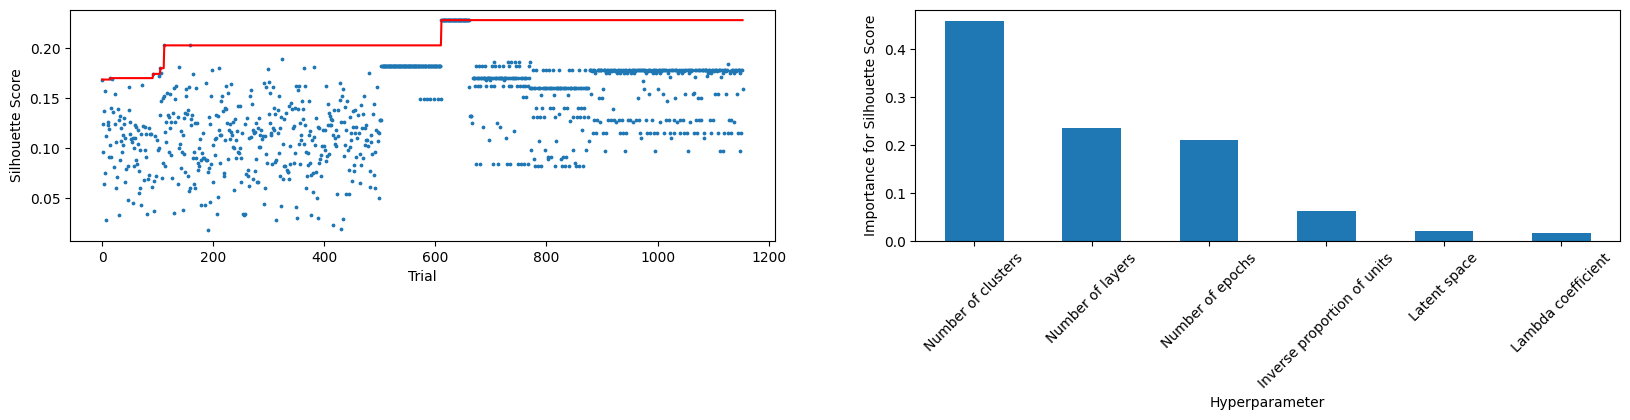

In [15]:
date = "2024051615"
with open(os.path.join(settings.optimization_path, f'optimization_optuna_{date}.pkl'), 'rb') as file:
    optimization_study = dill.load(file)

fig, axes = plt.subplots(1,2, figsize= (20, 3))

ax= axes[0]
optimization_results.plot.scatter(x='number', y='value', ax= ax, s= 3, xlabel= "Trial", ylabel= "Silhouette Score")
pd.Series(max_values).plot(ax= ax, c= "red")

ax= axes[1]
_ = pd.Series(param_importances).plot.bar(ax= ax, xlabel= "Hyperparameter", ylabel= "Importance for Silhouette Score", rot= 45)

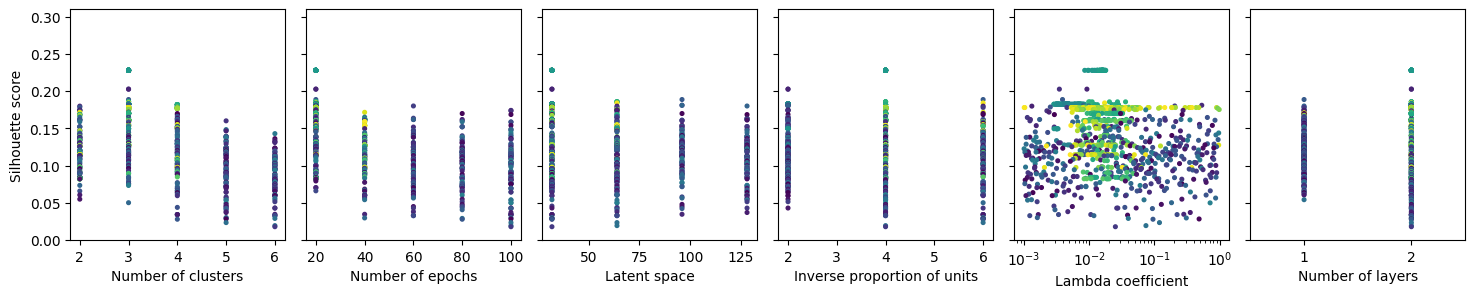

In [20]:
fig, axes = plt.subplots(1,6, sharey=True, figsize= (18, 3), gridspec_kw = {"wspace": 0.1})

for i, col in enumerate(["params_n_clusters", "params_n_epochs", "params_latent_space", "params_divisor_units",
                         "params_lambda_coeff", "params_num_layers"]):
    ax = axes[i]
    if col == "params_lambda_coeff":
        optimization_results.plot.scatter(x= col, y= "value", s= 7, ax=ax, ylabel= "Silhouette score", xlabel= "Lambda coefficient",
                                          logx= True, xticks= [0.001, 0.01, 0.1, 1], c= "number", colorbar= False, cmap = 'viridis')
    elif col == "params_n_clusters":
        optimization_results.plot.scatter(x= col, y= "value", s= 7, ax=ax, ylabel= "Silhouette score", xlabel= "Number of clusters",
                                          xticks= list(range(2,7)), c= "number", colorbar= False, cmap = 'viridis')
    elif col == "params_n_epochs":
        optimization_results.plot.scatter(x= col, y= "value", s= 7, ax=ax, ylabel= "Silhouette score", xlabel= "Number of epochs",
                                          xticks= [20,40,60,80,100], c= "number", colorbar= False, cmap = 'viridis')
    elif col == "params_num_layers":
        optimization_results.plot.scatter(x= col, y= "value", s= 7, ax=ax, ylabel= "Silhouette score", xlabel= "Number of layers",
                                          xticks= [1,2], c= "number", colorbar= False, cmap = 'viridis')
        ax.set_xlim(0.5,2.5)
    elif col == "params_latent_space":
        optimization_results.plot.scatter(x= col, y= "value", s= 7, ax=ax, ylabel= "Silhouette score", xlabel= "Latent space",
                                          c= "number", colorbar= False, cmap = 'viridis')
    elif col == "params_divisor_units":
        optimization_results.plot.scatter(x= col, y= "value", s= 7, ax=ax, ylabel= "Silhouette score", xlabel= "Inverse proportion of units",
                                          c= "number", colorbar= False, cmap = 'viridis')

_ = ax.set_ylim(0,0.31)

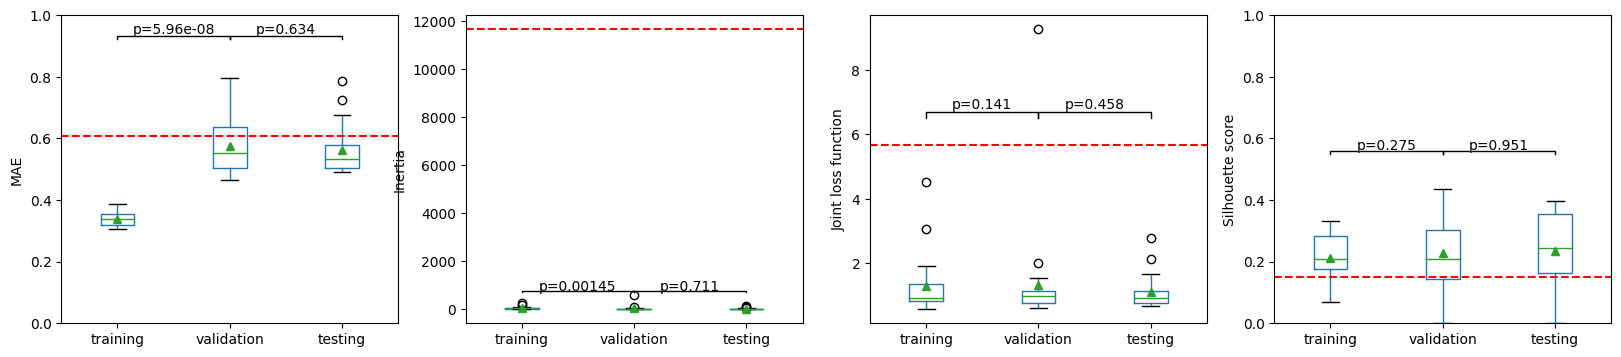

In [15]:
fig, axes = plt.subplots(1, 4, figsize= (20, 4))
ax, metric = axes[0], "au"
metric_index = ["training", "validation", "testing"]
metric_result = pd.DataFrame(optimization_results.iloc[0][[f"user_attrs_train_{metric}_loss_list", f"user_attrs_val_{metric}_loss_list",
                                           f"user_attrs_test_{metric}_loss_list"]].apply(eval).to_list(), index= metric_index).T
metric_result.boxplot(grid=False, showmeans= True, ax= ax)
bottom, top = ax.get_ylim()
y_range = top - bottom
bar_height = (y_range * 0.07 * 3) + top
bar_tips = bar_height - (y_range * 0.02)
text_height = bar_height + (y_range * 0.01)
for idx,met in enumerate(metric_index[:2]):
    pv = wilcoxon(metric_result[met], metric_result[metric_result.columns[idx + 1]]).pvalue
    ax.plot([idx+1, idx+1, idx+2, idx+2], [bar_tips, bar_height, bar_height, bar_tips], lw=1, c='k')
    ax.text((idx + idx + 3) * 0.5, text_height, 'p={:.3g}'.format(pv), ha='center', c='k')
ax.set_ylim(0, 1)
ax.axhline(optimization_results[f"user_attrs_test_{metric}_loss"].max(), c= "r", linestyle= '--')
ax.set_ylabel('MAE')

ax, metric = axes[1], "dist"
metric_result = pd.DataFrame(optimization_results.iloc[0][[f"user_attrs_train_{metric}_loss_list", f"user_attrs_val_{metric}_loss_list",
                                           f"user_attrs_test_{metric}_loss_list"]].apply(eval).to_list(), index= metric_index).T
metric_result.boxplot(grid=False, showmeans= True, ax= ax)
bottom, top = ax.get_ylim()
y_range = top - bottom
bar_height = (y_range * 0.07 * 3) + top
bar_tips = bar_height - (y_range * 0.02)
text_height = bar_height + (y_range * 0.01)
for idx,met in enumerate(metric_index[:2]):
    pv = wilcoxon(metric_result[met], metric_result[metric_result.columns[idx + 1]]).pvalue
    ax.plot([idx+1, idx+1, idx+2, idx+2], [bar_tips, bar_height, bar_height, bar_tips], lw=1, c='k')
    ax.text((idx + idx + 3) * 0.5, text_height, 'p={:.3g}'.format(pv), ha='center', c='k')
ax.axhline(optimization_results[optimization_results["params_n_clusters"] == 2][f"user_attrs_test_{metric}_loss"].mean(), c= "r", linestyle= '--')
ax.set_ylabel('Inertia')

ax, metric = axes[2], "total"
metric_result = pd.DataFrame(optimization_results.iloc[0][[f"user_attrs_train_{metric}_loss_list", f"user_attrs_val_{metric}_loss_list",
                                           f"user_attrs_test_{metric}_loss_list"]].apply(eval).to_list(), index= metric_index).T
metric_result.boxplot(grid=False, showmeans= True, ax= ax)
bottom, top = ax.get_ylim()
y_range = top - bottom
bar_height = (y_range * 0.07 * 3) + top - 5
bar_tips = bar_height - (y_range * 0.02)
text_height = bar_height + (y_range * 0.01)
for idx,met in enumerate(metric_index[:2]):
    pv = wilcoxon(metric_result[met], metric_result[metric_result.columns[idx + 1]]).pvalue
    ax.plot([idx+1, idx+1, idx+2, idx+2], [bar_tips, bar_height, bar_height, bar_tips], lw=1, c='k')
    ax.text((idx + idx + 3) * 0.5, text_height, 'p={:.3g}'.format(pv), ha='center', c='k')
best_params_lambda_coeff = best_trial["params_lambda_coeff"]
ax.axhline(optimization_results[optimization_results["params_lambda_coeff"].between(best_params_lambda_coeff - 0.001, best_params_lambda_coeff + 0.001)][f"user_attrs_test_{metric}_loss"].max(), c= "r", linestyle= '--')
ax.set_ylabel('Joint loss function')


ax, metric = axes[3], "silhscore"
metric_result = pd.DataFrame(optimization_results.iloc[0][[f"user_attrs_train_{metric}_list", f"user_attrs_val_{metric}_list",
                                           f"user_attrs_test_{metric}_list"]].apply(eval).to_list(), index= metric_index).T
metric_result.boxplot(grid=False, showmeans= True, ax= ax)
bottom, top = ax.get_ylim()
y_range = top - bottom
bar_height = (y_range * 0.07 * 3) + top
bar_tips = bar_height - (y_range * 0.02)
text_height = bar_height + (y_range * 0.01)
for idx,met in enumerate(metric_index[:2]):
    pv = wilcoxon(metric_result[met], metric_result[metric_result.columns[idx + 1]]).pvalue
    ax.plot([idx+1, idx+1, idx+2, idx+2], [bar_tips, bar_height, bar_height, bar_tips], lw=1, c='k')
    ax.text((idx + idx + 3) * 0.5, text_height, 'p={:.3g}'.format(pv), ha='center', c='k')
ax.set_ylabel('Silhouette score')
ax.set_ylim(0, 1)
_ = ax.axhline(optimization_results[f"user_attrs_test_{metric}"].mean(), c= "r", linestyle= '--')

In [20]:
transformed_Xs = [StandardScaler().set_output(transform="pandas").fit_transform(X) for X in Xs]
for transformed_X in transformed_Xs:
    print("transformed_X.shape", transformed_X.shape)
    display(transformed_X.head())

transformed_X.shape (57, 820)


,pathology_NF40_25%,pathology_NF39_0.01,pathology_NF62_75%,pathology_NF58_0.01,pathology_NF46_0.1,pathology_NF16_0.95,pathology_NF59_min,pathology_NF22_std,pathology_NF37_75%,pathology_NF20_0.05,pathology_NF50_0.05,pathology_NF32_max,pathology_NF1_75%,pathology_NF47_0.95,pathology_NF51_75%,pathology_NF35_25%,pathology_NF43_0.99,pathology_NF42_std,pathology_NF51_50%,pathology_NF31_mean,pathology_NF37_max,pathology_NF2_0.1,pathology_NF12_0.01,pathology_NF10_0.05,pathology_NF52_0.95,pathology_NF9_max,pathology_NF3_0.05,pathology_NF8_std,pathology_NF1_mean,pathology_NF11_75%,pathology_NF26_0.95,pathology_NF14_75%,pathology_NF13_0.05,pathology_NF6_max,pathology_NF6_75%,pathology_NF7_0.05,pathology_NF13_0.9,pathology_NF39_50%,pathology_NF34_50%,pathology_NF50_75%,...,pathology_NF1_0.1,pathology_NF27_0.1,pathology_NF30_std,pathology_NF41_0.9,pathology_NF12_mean,pathology_NF40_0.01,pathology_NF10_0.99,pathology_NF44_75%,pathology_NF61_0.95,pathology_NF10_std,pathology_NF56_0.05,pathology_NF36_0.1,pathology_NF60_0.95,pathology_NF42_mean,pathology_NF37_25%,pathology_NF57_std,pathology_NF16_0.01,pathology_NF40_75%,pathology_NF18_0.1,pathology_NF19_min,pathology_NF37_0.99,pathology_NF51_min,pathology_NF3_25%,pathology_NF58_50%,pathology_NF5_std,pathology_NF51_0.1,pathology_NF52_0.1,pathology_NF19_mean,pathology_NF58_std,pathology_NF5_0.1,pathology_NF4_50%,pathology_NF63_max,pathology_NF49_50%,pathology_NF32_0.95,pathology_NF15_0.1,pathology_NF26_0.1,pathology_NF6_25%,pathology_NF28_0.1,pathology_NF5_50%,pathology_NF3_mean
GI-19-025,0.367328,-0.810757,-0.552298,2.159154,-0.392823,0.441931,-0.184171,-0.591346,-0.440044,-0.408607,-0.397512,0.352164,-1.578852,-0.640526,0.347258,-0.328916,-0.147339,0.208691,0.501328,-0.481456,0.648261,-1.343235,0.777369,0.195135,-0.450035,-0.588966,0.277938,0.178926,-1.254479,-0.002122,-0.359196,0.466412,-0.445896,0.141737,-0.570399,0.567651,-0.491629,-0.514366,0.374401,-0.399421,...,-0.997183,0.0,-0.574583,0.200582,0.336276,0.620051,-0.138637,-0.603107,-1.751902,-0.076497,0.340044,0.254175,0.0,-0.619902,-0.552005,-2.213120,0.803842,0.338042,0.427834,0.160833,-0.641083,0.557378,-0.144719,1.310955,0.504045,0.426368,0.297837,-0.671993,-2.213120,-1.250558,1.540788,-0.598281,-0.465733,-0.329815,-0.777184,0.610302,-0.166576,-0.734012,-1.617581,-0.460401
GI-17-537,-0.303663,0.272336,0.152459,-0.593308,-1.758790,-0.249435,-0.114272,0.677331,0.038939,-1.280577,0.135865,-0.047571,1.332809,0.833532,-0.504356,-0.655547,-0.419668,0.050351,-0.512300,-0.915722,1.733786,1.390697,-0.905196,1.550503,0.688124,1.089445,2.114386,0.321308,0.877812,-0.251187,-1.919383,-0.696867,-0.186485,0.508966,1.032823,1.760602,0.461063,0.274486,-1.464600,0.220902,...,0.739044,0.0,-0.351699,-0.223509,-0.169687,0.610262,2.164373,-1.421021,0.957698,0.013219,1.992268,3.090191,0.0,-1.713897,-0.358414,0.845063,-0.593664,-0.479220,0.061369,-0.928706,-0.204153,-0.520251,1.924877,-1.176171,-1.730890,-0.088620,2.270284,-1.616223,0.845063,1.688782,-1.460851,-0.231866,0.404248,-0.278571,-0.021564,-1.411418,1.978989,-1.679340,1.402887,1.393700
GI-19-002,-0.877454,0.585332,-0.474427,0.721843,-0.572134,-0.559015,0.113210,-1.013564,0.055880,-0.443388,0.940534,-0.824338,-0.987130,-0.349796,-1.085054,0.174000,0.131665,-1.415408,-0.996200,-1.209541,-1.042427,-0.992317,0.483638,1.162100,-0.513452,-1.854003,0.277938,-1.304052,-0.808696,-0.471419,-1.066520,-0.632384,0.293275,0.468163,-0.416015,0.724488,-0.423728,0.651653,-0.003883,0.836532,...,-0.428210,0.0,-1.424596,-0.318386,-0.200722,-0.592933,-0.191360,-0.826900,-0.372768,-1.086035,0.728235,1.026116,0.0,-0.823868,0.223598,-0.648097,-0.654827,-1.040762,-0.791871,1.365427,-0.077273,-0.055764,0.051557,0.398578,0.414602,-0.802462,0.419373,-0.659839,-0.648097,-1.067840,1.088268,-0.963344,0.897686,-0.610395,0.327494,-0.387143,0.028476,-0.221882,-1.096296,-0.339713
GI-16-575,-0.830592,0.464602,-0.342237,-0.390973,-1.088246,-0.776971,-0.538961,-0.395434,0.036546,-0.502933,0.849531,0.645264,-0.641179,-0.231031,-0.882818,

transformed_X.shape (57, 648)


,CNV_HLA-DPB1,CNV_GPC3,CNV_SOX2,CNV_XRCC3,CNV_PAK1,CNV_ACVR1B,CNV_DDR2,CNV_FANCL,CNV_CDKN1B,CNV_DYNC2H1,CNV_SHH,CNV_SDHAF2,CNV_GRIN2A,CNV_LAG3,CNV_MGMT,CNV_ABL2,CNV_PTCH1,CNV_DDX3X,CNV_H3F3A,CNV_MIB1,CNV_NUP98,CNV_PDGFRB,CNV_FAT1,CNV_NHP2,CNV_ABCB1,CNV_HLA-A,CNV_HLA-DOA,CNV_C8orf34,CNV_NSD1,CNV_HDAC4,CNV_TSC2,CNV_KEL,CNV_BTG1,CNV_VEGFB,CNV_RPS6KB1,CNV_HRAS,CNV_PTCH2,CNV_STAG2,CNV_KDM5D,CNV_FLT1,...,CNV_SMARCA4,CNV_RHEB,CNV_CSF1R,CNV_IFNGR1,CNV_GNAQ,CNV_RPS15,CNV_HIST1H4E,CNV_MRE11,CNV_CEP57,CNV_ZRSR2,CNV_DOT1L,CNV_FUBP1,CNV_BCLAF1,CNV_HDAC2,CNV_AR,CNV_SYK,CNV_NTRK3,CNV_NUDT15,CNV_RSF1,CNV_P2RY8,CNV_IFIT1,CNV_IL10RA,CNV_CDK4,CNV_FRS2,CNV_BCR,CNV_PTPRT,CNV_CDK12,CNV_MSH3,CNV_CCND1,CNV_JAK2,CNV_NBN,CNV_HLA-DQB2,CNV_BRCA2,CNV_RAD51C,CNV_NOTCH2,CNV_DNM2,CNV_TNFRSF9,CNV_FGF9,CNV_ECT2L,CNV_CDKN1A
GI-19-025,-0.006658,0.086567,-0.128606,-0.011112,-0.239676,0.317410,-0.458080,0.390400,-0.108575,-0.100758,-0.300066,0.048992,0.284263,-0.001927,0.196520,-0.501469,0.335892,0.330985,-0.448948,-0.224255,0.173588,0.031587,0.235399,0.043957,-0.235133,-0.036362,-0.158009,-0.355880,0.043957,-0.245316,0.317851,-0.307308,0.348419,-0.104148,0.128325,0.123912,-0.001137,0.086567,0.380147,0.051677,...,0.218397,-0.291765,0.031587,-0.034308,-0.023856,0.207467,-0.242166,-0.261356,-0.269618,0.332231,0.121193,-0.107843,0.392330,-0.010976,0.184461,0.305003,-0.127706,0.152810,-0.239676,0.231812,0.083370,-0.125577,0.317410,0.317410,0.052999,-0.368711,-0.190724,0.021282,0.057707,0.339361,-0.432470,-0.161173,-0.087496,0.128325,-0.068611,0.179921,0.170748,0.051677,-0.029167,-0.154817
GI-17-537,-0.006658,0.086567,-0.128606,-0.011112,-0.239676,0.317410,1.129206,0.390400,-0.108575,-0.100758,-0.300066,0.048992,0.284263,-0.001927,-1.405336,1.205330,0.366526,0.330985,-0.448948,-0.224255,0.173588,0.031587,-1.594290,0.043957,-0.235133,-0.036362,-0.158009,-0.355880,0.043957,-0.245316,0.317851,-0.307308,0.348419,-0.104148,0.128325,0.123912,-0.001137,0.086567,0.380147,0.051677,...,0.218397,-0.291765,0.031587,-0.034308,0.005387,0.207467,-0.242166,-0.261356,-0.269618,0.332231,0.121193,-0.107843,0.392330,-0.010976,0.184461,0.336932,2.567866,0.152810,-0.239676,0.231812,-0.727818,-0.125577,0.317410,0.317410,0.993274,-0.368711,-0.190724,1.253638,0.057707,0.357566,-0.432470,-0.161173,-0.087496,0.128325,-0.068611,0.179921,0.170748,0.051677,-0.029167,-0.154817
GI-19-002,-0.006658,0.086567,-0.128606,-0.011112,-0.239676,0.317410,0.804100,-4.321369,-0.108575,-0.100758,-0.300066,0.048992,0.284263,-0.001927,0.196520,0.855745,0.335892,0.330985,1.050113,-0.224255,-3.191606,0.031587,0.235399,0.043957,-0.235133,-0.036362,-0.158009,-0.355880,0.043957,2.339778,0.317851,-0.307308,0.348419,-0.104148,0.128325,-4.436640,2.137836,0.086567,0.380147,0.051677,...,0.218397,-0.291765,0.031587,-0.034308,-0.023856,0.207467,1.783770,-0.261356,-0.269618,0.332231,0.121193,1.479008,0.392330,-0.010976,0.184461,0.305003,-0.127706,0.152810,-0.239676,0.231812,0.083370,-0.125577,0.317410,0.317410,0.052999,-0.368711,-0.190724,0.021282,0.057707,0.339361,-0.432470,-0.161173,-0.087496,0.128325,2.215595,0.179921,-2.401717,0.051677,-0.029167,-0.154817
GI-16-575,-1.334892,0.086567,-0.128606,-0.169451,1.452287,-2.096757,-0.458080,-0.204771,-1.011974,1.229244,1.259484,1.681344,0.552282,-2.125437,-1.802960,-0.501469,-0.675009,0.330985,-0.448948,-0.813356,1.604830,0.219546,0.075426,0.229914,0.918169,-2.277877,-2.160478,-1.105921,0.229914,2.078657,0.551489,-0.307308,-1.959946,1.065732,-1.666175,1.538853,-0.001137,0.086567,0.380147,0.434218,...,0.218397,1.335956,0.219546,-2.145559,-0.988867,1.939669,-1.283669,1.412344,1.370201,0.332231,1.754916,-0.107843,-0.532881,-2.132230,0.184461,-0.748645,-0.018426,0.553738,1.452287,2.101677,-0.929177,1.301289,-2.096757,-2.096757,-0.061359,0.875922,-0.735177,0.204210,1.026093,-0.261428,-0.871654,-2.155716,0.189575,-1.666175,-0.068611,1.948692,0.170748,0.434218,-2.228949,-2.155784
GI-14-974,-5.601158,0.086567,0.795413,0.079368,-0.239676,0.317410,-0.483578,0.390400,-0.108575,0.283954,1.17740

transformed_X.shape (57, 611)


,freebayes_SNV_HES4,freebayes_SNV_PPP1R3E,freebayes_SNV_UBA52,freebayes_SNV_FGF20,freebayes_SNV_RIT1,freebayes_SNV_IL6R,freebayes_SNV_SOX2,freebayes_SNV_SYNE1,freebayes_SNV_DOT1L,freebayes_SNV_RAD51D,freebayes_SNV_RHBDD3,freebayes_SNV_CRLF2,freebayes_SNV_BIRC8,freebayes_SNV_MYBBP1A,freebayes_SNV_MAPK11,freebayes_SNV_CCT7,freebayes_SNV_HOXA10-HOXA9,freebayes_SNV_CSDE1,freebayes_SNV_IDH2,freebayes_SNV_EPHA7,freebayes_SNV_GNA11,freebayes_SNV_PLCG2,freebayes_SNV_HOXB13,freebayes_SNV_SHC2,freebayes_SNV_KIT,freebayes_SNV_CASKIN1,freebayes_SNV_NTRK1,freebayes_SNV_BRCA1,freebayes_SNV_WHSC1,freebayes_SNV_TGFBR1,freebayes_SNV_ELF3,freebayes_SNV_CCBL2,freebayes_SNV_SMAD3,freebayes_SNV_STAG2,freebayes_SNV_MNX1,freebayes_SNV_TFEB,freebayes_SNV_QKI,freebayes_SNV_CXCR4,freebayes_SNV_CARD11,freebayes_SNV_SETBP1,...,freebayes_SNV_SPIDR,freebayes_SNV_MRPS15,freebayes_SNV_BCLAF1,freebayes_SNV_CACNA1S,freebayes_SNV_HLA-DPA1.2,freebayes_SNV_RUSC1,freebayes_SNV_MITF,freebayes_SNV_CBX4,freebayes_SNV_ARID1B,freebayes_SNV_IDO1,freebayes_SNV_HLA-F-AS1,freebayes_SNV_JUN,freebayes_SNV_RB1,freebayes_SNV_RET,freebayes_SNV_KDM5C,freebayes_SNV_TNFRSF17,freebayes_SNV_RAC1,freebayes_SNV_NTRK2,freebayes_SNV_C10orf54,freebayes_SNV_LMNA,freebayes_SNV_PDGFRB,freebayes_SNV_AGO1,freebayes_SNV_GATA3,freebayes_SNV_EPCAM,freebayes_SNV_ERBB3,freebayes_SNV_BAGE3,freebayes_SNV_FOXQ1,freebayes_SNV_ETV6,freebayes_SNV_TGFBR2,freebayes_SNV_TBX3,freebayes_SNV_MAP3K1,freebayes_SNV_MIR650-MIR5571,freebayes_SNV_MAGEB1-NR0B1,freebayes_SNV_TAP2.2,freebayes_SNV_SDHD,freebayes_SNV_PMS2,freebayes_SNV_PTPRT,freebayes_SNV_HEY2,freebayes_SNV_SOX9,freebayes_SNV_RICTOR
GI-19-025,0.0,-0.133631,-0.133631,-0.133631,-0.133631,-0.133631,-0.235702,-0.350325,-0.133631,-0.190693,-0.133631,-0.133631,0.0,0.0,-0.133631,-0.133631,-0.133631,-0.133631,-0.133631,0.0,-0.133631,-0.133631,-0.133631,-0.133631,-0.133631,-0.133631,-0.133631,-0.190693,-0.133631,-0.235702,-0.133631,-0.133631,-0.190693,-0.133631,-0.133631,-0.190693,-0.133631,-0.133631,-0.133631,-0.133631,...,-0.133631,0.0,-0.133631,-0.133631,-0.133631,-0.190693,-0.133631,0.0,-0.258544,-0.133631,-0.133631,-0.133631,-0.235702,-0.190693,-0.274721,-0.133631,-0.133631,4.242641,-0.133631,-0.221540,-0.133631,0.0,-0.133631,-0.133631,-0.133631,-0.133631,-0.133631,-0.133631,-0.310087,-0.190693,0.0,-0.133631,-0.133631,-0.133631,0.0,-0.190693,-0.133631,-0.180579,-0.190693,-0.190693
GI-17-537,0.0,-0.133631,-0.133631,7.483315,-0.133631,-0.133631,-0.235702,-0.350325,-0.133631,-0.190693,-0.133631,-0.133631,0.0,0.0,-0.133631,-0.133631,-0.133631,-0.133631,-0.133631,0.0,-0.133631,-0.133631,-0.133631,-0.133631,-0.133631,-0.133631,-0.133631,-0.190693,-0.133631,4.242641,-0.133631,-0.133631,-0.190693,-0.133631,-0.133631,-0.190693,-0.133631,-0.133631,-0.133631,-0.133631,...,-0.133631,0.0,-0.133631,-0.133631,-0.133631,-0.190693,-0.133631,0.0,-0.258544,7.483315,-0.133631,-0.133631,-0.235702,-0.190693,-0.274721,-0.133631,-0.133631,-0.235702,-0.133631,2.935399,-0.133631,0.0,-0.133631,7.483315,-0.133631,-0.133631,-0.133631,-0.133631,-0.310087,-0.190693,0.0,-0.133631,-0.133631,-0.133631,0.0,-0.190693,-0.133631,-0.180579,-0.190693,5.244044
GI-19-002,0.0,-0.133631,-0.133631,-0.133631,-0.133631,-0.133631,-0.235702,-0.350325,-0.133631,-0.190693,-0.133631,-0.133631,0.0,0.0,-0.133631,-0.133631,-0.133631,-0.133631,-0.133631,0.0,-0.133631,-0.133631,-0.133631,-0.133631,-0.133631,-0.133631,-0.133631,-0.190693,-0.133631,-0.235702,-0.133631,-0.133631,-0.190693,-0.133631,-0.133631,-0.190693,-0.133631,-0.133631,-0.133631,-0.133631,...,-0.133631,0.0,-0.133631,-0.133631,-0.133631,-0.190693,-0.133631,0.0,-0.258544,-0.133631,-0.133631,-0.133631,-0.235702,-0.190693,-0.274721,-0.133631,-0.133631,-0.235702,-0.133631,-0.221540,-0.133631,0.0,-0.133631,-0.133631,-0.133631,-0.133631,-0.133631,-0.133631,-0.310087,-0.190693,0.0,-0.133631,-0.133631,-0.133631,0.0,-0.190693,-0.133631,-0.180579,-0.190693,-0.190693
GI-16-575,0.0,-0.133631,-0.133631,-0.133631,-0.133631,-0.133631,-0.235702,-0.350325,-0.133631

transformed_X.shape (57, 2000)


,rna_expr_IL6ST,rna_expr_LPP,rna_expr_REG1A,rna_expr_WASF2,rna_expr_UBXN7,rna_expr_NFAT5,rna_expr_MT-ND4,rna_expr_NOTCH2,rna_expr_ARID1A,rna_expr_PLEC,rna_expr_TLK1,rna_expr_LIMS1,rna_expr_OSBPL8,rna_expr_PUM1,rna_expr_MTATP6P1,rna_expr_EVI5,rna_expr_PHC3,rna_expr_RABGAP1L,rna_expr_RANBP2,rna_expr_VPS13B,rna_expr_ZBTB20,rna_expr_RGPD6,rna_expr_NCOA2,rna_expr_ACTB,rna_expr_MAP4K4,rna_expr_MT-CO3,rna_expr_RPS3A,rna_expr_ELK4,rna_expr_MT-CYB,rna_expr_AEBP1,rna_expr_AC008755.1,rna_expr_SFT2D2,rna_expr_FCHO2,rna_expr_BAZ2B,rna_expr_MT-CO1,rna_expr_CLASP1,rna_expr_MT-ND2,rna_expr_AGO3,rna_expr_RC3H2,rna_expr_MT-ATP6,...,rna_expr_CRK,rna_expr_RPS8,rna_expr_METTL25,rna_expr_LRBA,rna_expr_DICER1,rna_expr_TP53,rna_expr_S100A14,rna_expr_UBE2H,rna_expr_ANKRD13A,rna_expr_LIMK1,rna_expr_TUFT1,rna_expr_MSL2,rna_expr_UBTF,rna_expr_PPIP5K2,rna_expr_C5orf24,rna_expr_SENP5,rna_expr_TPP2,rna_expr_CARD8,rna_expr_DOCK6,rna_expr_PACRGL,rna_expr_ZNF528,rna_expr_CHMP3,rna_expr_STT3B,rna_expr_PYGL,rna_expr_USP40,rna_expr_SSH2,rna_expr_KANSL1L,rna_expr_SUMO2,rna_expr_PPHLN1,rna_expr_BTN2A2,rna_expr_NISCH,rna_expr_MFN2,rna_expr_RNF103,rna_expr_KCNK1,rna_expr_VASH1,rna_expr_TBC1D4,rna_expr_EPS15L1,rna_expr_MANBA,rna_expr_ZNF561,rna_expr_CHD8
GI-19-025,-0.154479,1.720873,-0.663992,0.211719,-0.536917,-0.291813,-0.101337,0.797264,-0.287089,0.420470,-0.833504,0.013235,-0.154141,-1.190886,0.123233,-0.778648,0.328425,-0.091642,-0.118187,-0.888360,1.307642,0.320068,0.203631,1.914434,0.204706,0.375989,-0.964422,0.316027,0.174000,0.962733,0.432225,1.567212,0.084722,-0.070915,0.212303,0.184559,0.228251,0.762272,-0.874695,0.002342,...,-0.297231,-0.768060,0.319112,-0.996958,-0.501872,-1.251279,0.019867,-0.058622,-0.778932,-0.433622,-0.062424,-0.273152,1.125109,-0.756184,-0.122689,0.299268,-0.193899,-0.433264,1.347226,-1.172645,1.002903,-0.526602,-0.490245,-0.823264,-0.180741,-0.935361,-0.440208,-0.696468,-0.436051,0.032352,2.049733,0.474814,0.043321,0.471066,1.272184,0.488833,0.637678,-1.155892,0.736838,-0.601676
GI-17-537,-0.429055,-0.470332,-0.668303,-0.296201,-1.449938,-1.026930,-0.616297,-2.086651,-0.938892,1.664829,-1.143643,0.538871,-0.523919,0.656162,-0.639939,0.996466,-0.974233,-0.370308,-1.076658,-1.858994,-1.365297,-1.543699,-1.468984,-0.740266,0.980846,-0.688696,-0.258508,-0.999422,-0.596471,1.547349,-1.604283,-1.054664,-0.339756,-1.680722,-0.753372,-1.119537,-0.679901,-2.099572,-0.536688,-0.668643,...,-0.332379,-0.332147,-1.666606,-1.550026,-0.997421,1.383692,2.559392,2.985149,-2.035026,0.708302,2.225503,-1.957719,-1.242133,-1.602393,0.210745,-1.711640,-1.805713,-1.024050,-0.722107,-1.956739,-1.853178,-0.029883,-0.811547,-0.446318,-1.989946,-0.655935,-0.853383,1.125200,-0.899553,-1.529776,0.006706,0.034058,-0.788790,0.856090,-1.495812,-1.646213,-1.959113,0.465773,-1.680937,-0.149380
GI-19-002,0.552056,-0.358276,-0.433958,0.704828,0.091123,-0.220616,-0.206978,-1.143044,0.284007,-0.543119,2.075834,-0.962970,0.114176,-1.078904,-0.250206,0.605324,1.225464,3.558592,0.387361,-0.170385,0.604256,-1.156731,0.131212,-0.880460,-1.373975,-0.378320,0.562562,1.967183,-0.085747,-0.672895,0.536258,0.745386,0.636623,0.608447,-0.391356,0.308009,-0.358218,-0.572429,-0.262464,-0.266370,...,1.151239,-0.027118,0.345803,1.301392,-0.222371,0.304776,-0.016225,-0.185786,-1.062198,-1.337172,0.364815,1.229051,-0.114266,1.465939,-0.319840,0.754232,0.224286,-0.177498,0.458493,1.411835,0.334925,0.356990,0.683048,-1.274692,1.224445,0.669142,1.804476,-0.233033,0.269615,-0.545371,0.725072,-1.426800,2.518113,2.680890,-0.038420,1.299193,0.560943,-0.087747,0.902409,-0.214801
GI-16-575,-0.250413,-0.690903,-0.522742,1.097555,-0.459313,0.234821,0.071028,0.768554,0.507990,0.081801,1.896884,-0.641695,0.203193,0.413431,0.039503,0.078599,0.695394,1.795222,0.150031,-0.081458,0.065993,-0.019624,1.925951,-0.813657,0.326886,-0.065789,-0.670034,1.411321,-0.166989,-0.739842,0.640142,0.321847,0.003208,2.213259,0.233433,0.399230,-0.219375,0.476321,-0.141259,-0.022543,...,-0.347872,-1.156174,-0.046209,0.664

In [93]:
list_of_genes = [
    "SATB1",
    "SDR16C5",
    "SCIN",
    "SLC44A1",
    "CHD3",
    "SDCBP2",
    "CEACAM6",
    "TMBIM1",
    "SGSM2",
    "CAPN5",
    "BEX4",
    "WDR6",
    "LDLR",
    "TTLL12",
    "GORASP2",
    "RNF103",
    "MEGF8",
    "CLIP2",
    "CBLC",
    "TJP3",
    "RASSF7",
    "KRT19",
    "EPS8L2",
    "SRI",
    "BAT2L1",
    "VAMP8",
    "TMPRSS4",
    "SERINC2",
    "MARCH9",
    "UNC93B1",
    "TFF1",
    "ADAMTS9",
    "ABL1",
    "EPN3",
    "PPAP2C",
    "LSR",
    "MAP3K11",
    "KLHL9",
    "FILIP1L",
    "CYP2S1",
    "KIAA1432",
    "BICD2",
    "PRKD2",
]



genes = transformed_Xs[3].columns.str.split("_").str[-1]
print("list_of_genes", len(list_of_genes))
list_of_genes = [gene for gene in list_of_genes if gene in genes]
print("list_of_genes", len(list_of_genes))

for gene_name in list_of_genes:
    cph = CoxPHFitter()
    gene_clinical_data = clinical_data.copy()
    gene = transformed_Xs[3][transformed_Xs[3].columns[transformed_Xs[3].columns.str.split("_").str[-1].str.contains(gene_name)]].squeeze()
    gene_clinical_data[gene_name] = gene
    cph.fit(gene_clinical_data[[gene_name, "label_days_to_death", "label_deceased"]], duration_col= "label_days_to_death", event_col= "label_deceased")

    threshold = transformed_Xs[3][transformed_Xs[3].columns[transformed_Xs[3].columns.str.split("_").str[-1].str.contains(gene_name)]].squeeze()
    # cl = threshold > threshold.median()
    # cl = cl.astype(int)
    
    cl = pd.cut(threshold.squeeze(), int(best_trial["params_n_clusters"]), labels=list(range(int(best_trial["params_n_clusters"]))))
    
    logrank_test = multivariate_logrank_test(event_durations= clinical_data["label_days_to_death"], groups= cl, event_observed= clinical_data["label_deceased"])
    print(gene_name, "\t", cph.summary["p"].values[0], "\t", logrank_test.p_value)


list_of_genes 43
list_of_genes 6
SLC44A1 	 0.1193665084547188 	 0.4288712414657141
CHD3 	 0.6333633745684283 	 0.6684746496970939
RNF103 	 0.06189158825340226 	 0.04210704749045478
KRT19 	 0.013212366029412585 	 0.03646671388562558
ADAMTS9 	 0.559457189733259 	 0.7039160229842543
FILIP1L 	 0.6170065021640486 	 0.8868703251709822


In [23]:
list_of_genes = [
    "SATB1",
    "SDR16C5",
    "SCIN",
    "SLC44A1",
    "CHD3",
    "SDCBP2",
    "CEACAM6",
    "TMBIM1",
    "SGSM2",
    "CAPN5",
    "BEX4",
    "WDR6",
    "LDLR",
    "TTLL12",
    "GORASP2",
    "RNF103",
    "MEGF8",
    "CLIP2",
    "CBLC",
    "TJP3",
    "RASSF7",
    "KRT19",
    "EPS8L2",
    "SRI",
    "BAT2L1",
    "VAMP8",
    "TMPRSS4",
    "SERINC2",
    "MARCH9",
    "UNC93B1",
    "TFF1",
    "ADAMTS9",
    "ABL1",
    "EPN3",
    "PPAP2C",
    "LSR",
    "MAP3K11",
    "KLHL9",
    "FILIP1L",
    "CYP2S1",
    "KIAA1432",
    "BICD2",
    "PRKD2",
]



genes = transformed_Xs[3].columns.str.split("_").str[-1]
print("list_of_genes", len(list_of_genes))
list_of_genes = [gene for gene in list_of_genes if gene in genes]
print("list_of_genes", len(list_of_genes))

df_individuals = pd.DataFrame()

for gene_name in list_of_genes:
    cph = CoxPHFitter()
    gene_clinical_data = clinical_data.copy()
    gene = transformed_Xs[3][transformed_Xs[3].columns[transformed_Xs[3].columns.str.split("_").str[-1].str.contains(gene_name)]].squeeze()
    gene_clinical_data[gene_name] = gene
    cph.fit(gene_clinical_data[[gene_name, "label_days_to_death", "label_deceased"]], duration_col= "label_days_to_death", event_col= "label_deceased")

    threshold = transformed_Xs[3][transformed_Xs[3].columns[transformed_Xs[3].columns.str.split("_").str[-1].str.contains(gene_name)]].squeeze()
    # cl = threshold > threshold.median()
    # cl = cl.astype(int)
    
    cl = pd.cut(threshold.squeeze(), int(best_trial["params_n_clusters"]), labels=list(range(int(best_trial["params_n_clusters"]))))
    
    logrank_test = multivariate_logrank_test(event_durations= clinical_data["label_days_to_death"], groups= cl, event_observed= clinical_data["label_deceased"])
    print(gene_name, "\t", cph.summary["p"].values[0], "\t", logrank_test.p_value)
    df_individuals = pd.concat([df_individuals, cph.summary])

list_of_genes 43
list_of_genes 6
SLC44A1 	 0.1193665084547188 	 0.4288712414657141
CHD3 	 0.6333633745684283 	 0.6684746496970939
RNF103 	 0.06189158825340226 	 0.04210704749045478
KRT19 	 0.013212366029412585 	 0.03646671388562558
ADAMTS9 	 0.559457189733259 	 0.7039160229842543
FILIP1L 	 0.6170065021640486 	 0.8868703251709822


In [24]:
df_individuals

,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p)
covariate,,,,,,,,,,,
SLC44A1,-0.320122,0.726060,0.205544,-0.722981,0.082737,0.485303,1.086256,0.0,-1.557438,0.119367,3.066530
CHD3,-0.083510,0.919882,0.175074,-0.426650,0.259629,0.652692,1.296450,0.0,-0.476998,0.633363,0.658895
RNF103,-0.351570,0.703582,0.188300,-0.720632,0.017492,0.486445,1.017646,0.0,-1.867072,0.061892,4.014113
KRT19,0.385478,1.470317,0.155561,0.080585,0.690372,1.083921,1.994457,0.0,2.477993,0.013212,6.241967
ADAMTS9,-0.105825,0.899582,0.181317,-0.461200,0.249549,0.630527,1.283447,0.0,-0.583648,0.559457,0.837900
FILIP1L,0.086813,1.090692,0.173591,-0.253420,0.427045,0.776142,1.532722,0.0,0.500097,0.617007,0.696642


In [106]:
cph = CoxPHFitter()
gene_clinical_data = clinical_data.copy()
for gene_name in list_of_genes:
    gene_clinical_data[gene_name] = transformed_Xs[3][transformed_Xs[3].columns[transformed_Xs[3].columns.str.split("_").str[-1].str.contains(gene_name)]].squeeze()
cph.fit(gene_clinical_data[list_of_genes + ["label_days_to_death", "label_deceased"]], duration_col= "label_days_to_death", event_col= "label_deceased").print_summary()

<lifelines.CoxPHFitter: fitted with 57 total observations, 20 right-censored observations>
             duration col = 'label_days_to_death'
                event col = 'label_deceased'
      baseline estimation = breslow
   number of observations = 57
number of events observed = 37
   partial log-likelihood = -124.91
         time fit was run = 2024-05-29 11:48:36 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
SLC44A1    -0.28       0.76       0.21            -0.70             0.14                 0.50                 1.15
CHD3       -0.51       0.60       0.28            -1.06             0.03                 0.35                 1.03
RNF103     -0.74       0.48       0.31            -1.35            -0.14                 0.26                 0.87
KRT19       0.29       1.34       0.17            -0.04             0.62                 0.96                 1.86
ADAMTS9    -0.21       0.81       0.21            -0.62             0.20                 0.54                 1.22
FILIP1L     0.16       1.18       0.20            -0.23             0.56                 0.80                 1.75

            cmp to     z    p   -log2(p)
covariate                               
SLC44A1       0.00 -1.31 0.19       2.40
CHD3          0.00 -1.84 0.07       3.93
RNF103        0.00 -2.40 0.02       5.95
KRT19         0.00  1.73 0.08       3.57
ADAMTS9       0.00 -1.00 0.32       1.65
FILIP1L       0.00  0.82 0.41       1.28
---
Concordance = 0.71
Partial AIC = 261.83
log-likelihood ratio test = 18.29 on 6 df
-log2(p) of ll-ratio test = 7.50

In [26]:
df_biomarkers = cph.summary
df_biomarkers["model"] = "combined"
df_individuals["model"] = "individual"
df_biomarkers = pd.concat([df_biomarkers, df_individuals])
df_biomarkers = df_biomarkers.reset_index()
df_biomarkers

,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p),model
covariate,,,,,,,,,,,,
SLC44A1,-0.280997,0.755031,0.213999,-0.700427,0.138434,0.496373,1.148474,0.0,-1.313074,0.189158,2.402337,combined
CHD3,-0.512320,0.599104,0.278226,-1.057633,0.032992,0.347277,1.033543,0.0,-1.841383,0.065565,3.930921,combined
RNF103,-0.742628,0.475862,0.308886,-1.348034,-0.137222,0.259750,0.871776,0.0,-2.404213,0.016207,5.947210,combined
KRT19,0.290867,1.337586,0.168425,-0.039240,0.620974,0.961519,1.860739,0.0,1.726979,0.084171,3.570527,combined
ADAMTS9,-0.208633,0.811693,0.209299,-0.618853,0.201586,0.538562,1.223341,0.0,-0.996818,0.318853,1.649037,combined
FILIP1L,0.164425,1.178715,0.200498,-0.228545,0.557394,0.795691,1.746116,0.0,0.820080,0.412170,1.278687,combined
SLC44A1,-0.320122,0.726060,0.205544,-0.722981,0.082737,0.485303,1.086256,0.0,-1.557438,0.119367,3.066530,individual
CHD3,-0.083510,0.919882,0.175074,-0.426650,0.259629,0.652692,1.296450,0.0,-0.476998,0.633363,0.658895,individual
RNF103,-0.351570,0.703582,0.188300,-0.720632,0.017492,0.486445,1.017646,0.0,-1.867072,0.061892,4.014113,individual


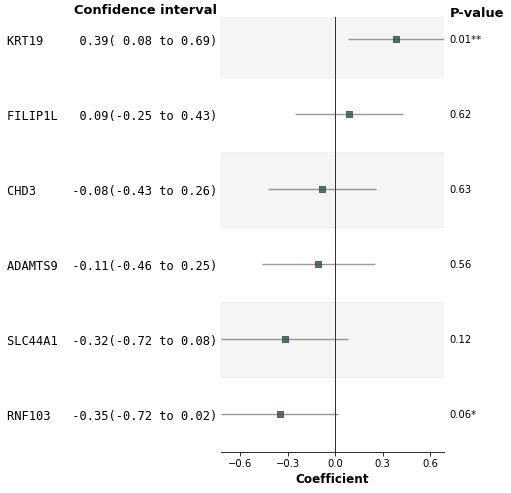

In [59]:
import forestplot as fp
import matplotlib.pyplot as plt

_ = fp.forestplot(
    dataframe=df_biomarkers[df_biomarkers["model"] == "individual"],
    estimate="coef",
    ll="coef lower 95%",
    hl="coef upper 95%",
    varlabel="covariate",
    pval="p",
    color_alt_rows=True,
    ylabel="Confidence interval",
    xlabel="Coefficient",
    form_ci_report= True,
    sort=True,
)

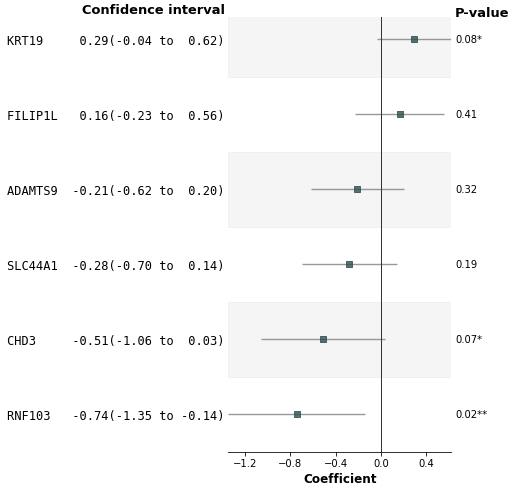

In [60]:
_ = fp.forestplot(
    dataframe=df_biomarkers[df_biomarkers["model"] == "combined"],
    estimate="coef",
    ll="coef lower 95%",
    hl="coef upper 95%",
    varlabel="covariate",
    pval="p",
    color_alt_rows=True,
    ylabel="Confidence interval",
    xlabel="Coefficient",
    form_ci_report= True,
    sort=True,
)

<Axes: xlabel='Coefficient'>

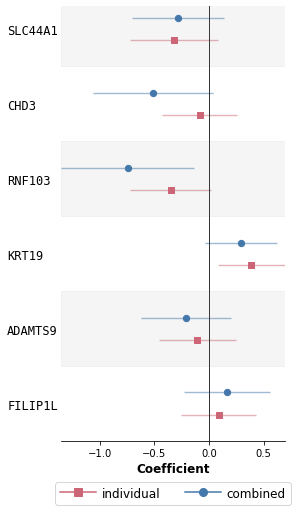

In [45]:
import forestplot as fp

fp.mforestplot(
    dataframe=df_biomarkers,
    estimate="coef",
    ll="coef lower 95%",
    hl="coef upper 95%",
    model_col="model",
    varlabel="covariate",
    sort=True,
    pval="p",
    color_alt_rows=True,
    ylabel="Confidence interval",
    xlabel="Coefficient",
    mcolor=["#CC6677", "#4477AA"],
    table=True,
    form_ci_report= True,
    group_order = "coef"
)

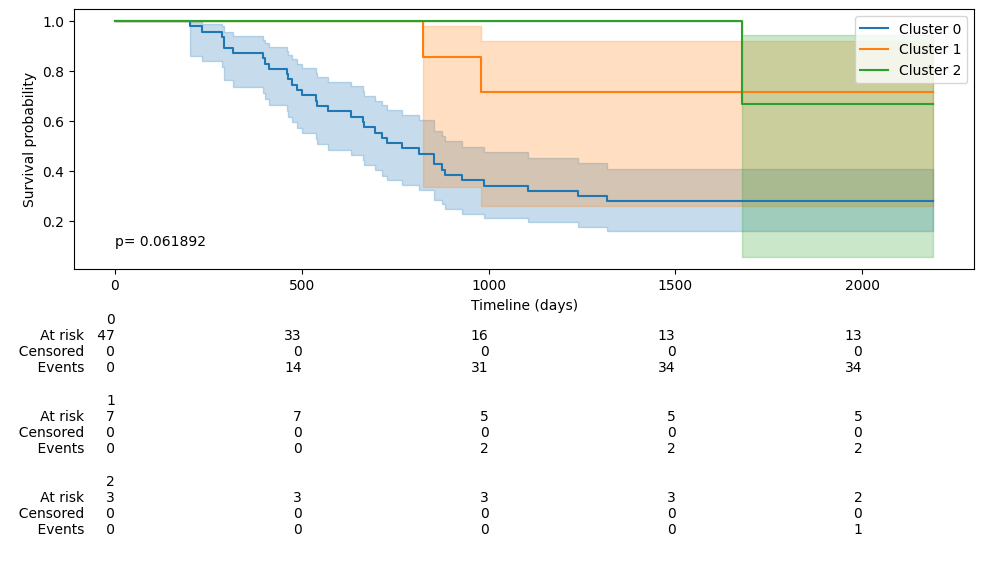

In [97]:
gene_name = "RNF103"
threshold = transformed_Xs[3][transformed_Xs[3].columns[transformed_Xs[3].columns.str.split("_").str[-1].str.contains(gene_name)]].squeeze()
# cl_gene = threshold > threshold.median()
# cl_gene = cl_gene.astype(int)
cl_gene = pd.cut(threshold.squeeze(), int(best_trial["params_n_clusters"]), labels=list(range(int(best_trial["params_n_clusters"]))))

cph = CoxPHFitter()
gene_clinical_data = clinical_data.copy()
gene = transformed_Xs[3][transformed_Xs[3].columns[transformed_Xs[3].columns.str.split("_").str[-1].str.contains(gene_name)]].squeeze()
gene_clinical_data[gene_name] = gene
cph.fit(gene_clinical_data[[gene_name, "label_days_to_death", "label_deceased"]], duration_col= "label_days_to_death", event_col= "label_deceased")

plt.figure(figsize=(10, 6)) 
ax = plt.subplot(111)
ax.text(0, 0.1, f"p= {round(cph.summary['p'].values[0], 6)}")
kmfs = []
colors = ['y', 'm']
for cluster in sorted(cl_gene.unique()):
    cli_clus = cl_gene[cl_gene == cluster]
    duration = clinical_data[cl_gene == cluster]["label_days_to_death"]
    event = clinical_data[cl_gene == cluster]["label_deceased"]
    kmf = KaplanMeierFitter().fit(duration, label = str(cluster), event_observed= event)
    kmfs.append(kmf)
    ax = kmf.plot(ax=ax)

add_at_risk_counts(*kmfs, ax=ax)
ax.set_ylabel("Survival probability")
ax.set_xlabel("Timeline (days)")
for i,cl in enumerate(ax.legend().get_texts()):
    cl.set_text(f'Cluster {i}')
plt.tight_layout()

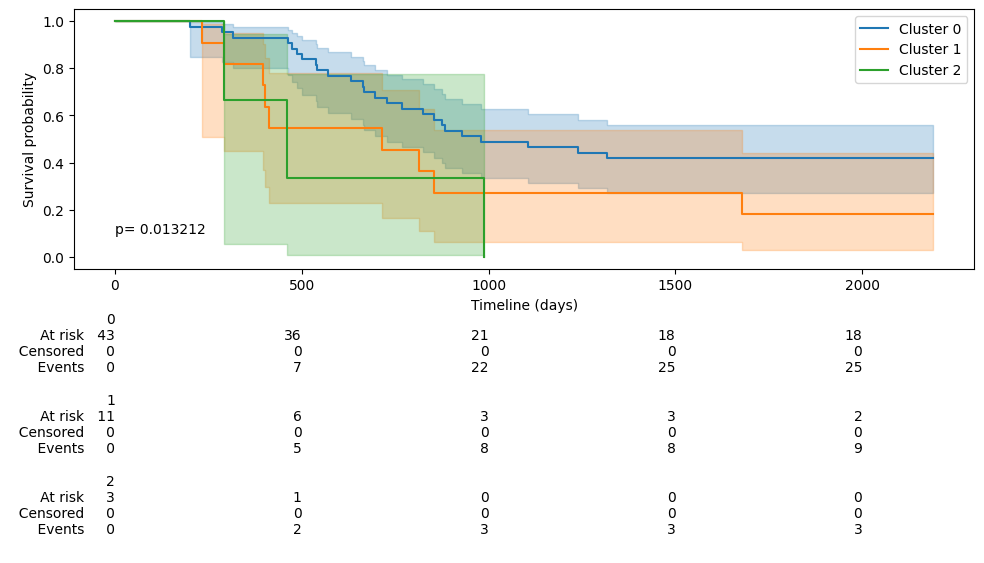

In [98]:
gene_name = "KRT19"
threshold = transformed_Xs[3][transformed_Xs[3].columns[transformed_Xs[3].columns.str.split("_").str[-1].str.contains(gene_name)]].squeeze()
# cl_gene = threshold > threshold.median()
# cl_gene = cl_gene.astype(int)
cl_gene = pd.cut(threshold.squeeze(), int(best_trial["params_n_clusters"]), labels=list(range(int(best_trial["params_n_clusters"]))))

cph = CoxPHFitter()
gene_clinical_data = clinical_data.copy()
gene = transformed_Xs[3][transformed_Xs[3].columns[transformed_Xs[3].columns.str.split("_").str[-1].str.contains(gene_name)]].squeeze()
gene_clinical_data[gene_name] = gene
cph.fit(gene_clinical_data[[gene_name, "label_days_to_death", "label_deceased"]], duration_col= "label_days_to_death", event_col= "label_deceased")

plt.figure(figsize=(10, 6)) 
ax = plt.subplot(111)
ax.text(0, 0.1, f"p= {round(cph.summary['p'].values[0], 6)}")
kmfs = []
colors = ['y', 'm']
for cluster in sorted(cl_gene.unique()):
    cli_clus = cl_gene[cl_gene == cluster]
    duration = clinical_data[cl_gene == cluster]["label_days_to_death"]
    event = clinical_data[cl_gene == cluster]["label_deceased"]
    kmf = KaplanMeierFitter().fit(duration, label = str(cluster), event_observed= event)
    kmfs.append(kmf)
    ax = kmf.plot(ax=ax)

add_at_risk_counts(*kmfs, ax=ax)
ax.set_ylabel("Survival probability")
ax.set_xlabel("Timeline (days)")
for i,cl in enumerate(ax.legend().get_texts()):
    cl.set_text(f'Cluster {i}')
plt.tight_layout()

In [15]:
batch_size = int(best_trial["user_attrs_batch_size"])
pl.seed_everything(55)
full_data = MultiViewDataset(Xs=transformed_Xs)
full_dataloader = DataLoader(dataset=full_data, batch_size=batch_size, shuffle=True)
total_results = Optimization().training(n_clusters = optimization_study.best_params["n_clusters"], latent_space=optimization_study.best_params["latent_space"],
                                            in_channels_list = eval(best_trial["user_attrs_num_features"]),
                                            hidden_channels_list = [view_hidden[1:] for view_hidden in eval(best_trial["user_attrs_num_units"])], 
                                            train_dataloader = full_dataloader, val_dataloader = full_dataloader, test_dataloader = full_dataloader,
                                            n_epochs = optimization_study.best_params["n_epochs"],
                                            log_every_n_steps = np.ceil(len(full_data) / batch_size).astype(int),
                                            lambda_coeff = optimization_study.best_params["lambda_coeff"])

Global seed set to 55
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/alberto/anaconda3/envs/edc_mo_pdac_val/lib/python3.11/site-packages/pytorch_lightning/loops/utilities.py:70: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
/home/alberto/anaconda3/envs/edc_mo_pdac_val/lib/python3.11/site-packages/pytorch_lightning/trainer/configuration_validator.py:72: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/alberto/anaconda3/envs/edc_mo_pdac_val/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.003981071705534969
Restoring states from the checkpoint path at /home/alberto/PycharmProjects/edc_mo_pdac_val/.lr_find_147ac71c-215b-4c10-8244-b0c9046e8bb4.ckpt
Restored all states from the checkpoint at /home/alberto/PycharmProjects/edc_mo_pdac_val/.lr_find_147ac71c-215b-4c10-8244-b0c9046e8bb4.ckpt
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | encoder_0 | FCN        | 179 K 
1 | decoder_0 | FCN        | 221 K 
2 | encoder_1 | FCN        | 112 K 
3 | decoder_1 | FCN        | 147 K 
4 | encoder_2 | FCN        | 99.2 K
5 | decoder_2 | FCN        | 132 K 
6 | encoder_3 | FCN        | 1.1 M 
7 | decoder_3 | FCN        | 1.1 M 
8 | encoder_4 | Sequential | 8.2 K 
9 | decoder_4 | FCN        | 8.

In [16]:
model = total_results["model"]
model_path = os.path.join("outputs", "models", "model_state_dict.pt")
torch.save(model.state_dict(), model_path)
model_path = os.path.join("outputs", "models", "model.pt")
torch.save(model, model_path)
model = model.eval()

In [18]:
model_path = os.path.join("outputs", "models", "model.pt")
model = torch.load(model_path)
model = model.eval()

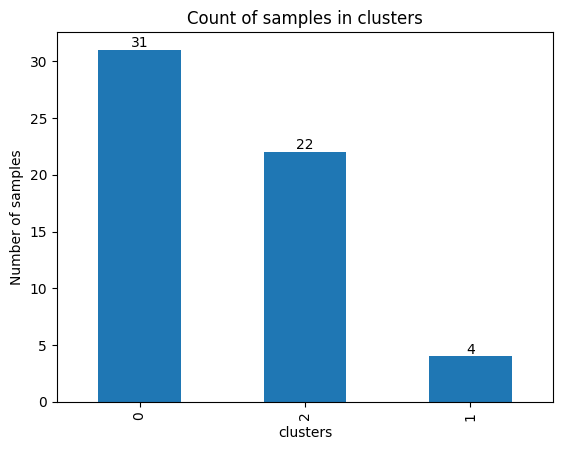

In [17]:
batch_size = int(best_trial["user_attrs_batch_size"])
full_data = MultiViewDataset(Xs=transformed_Xs)
full_dataloader = DataLoader(dataset=full_data, batch_size=batch_size, shuffle=False)
with torch.no_grad():
    z_full = torch.vstack([model.autoencoder.encode(batch) for batch in full_dataloader])
    clusters = model.predict_cluster_from_embedding(z_full).detach().cpu().numpy()
z_full = pd.DataFrame(z_full)
clinical_data["clusters"] = clusters
ax = clinical_data["clusters"].value_counts().plot(kind="bar", title= "Count of samples in clusters", x= "clusters", ylabel= "Number of samples")
for container in ax.containers:
    ax.bar_label(container)

In [69]:
clinical_data.to_csv(settings.clinical_data_path)

In [18]:
clustering_statistical_table = pd.DataFrame([], columns= ["Deep clustering", "K-Means", "HC"], index= ["Overall Survival", "Diagnosis age", "TNM Stage",
                                                                                                       "Grade", "Sex"])
clustering_statistical_table

,Deep clustering,K-Means,HC
Overall Survival,NaN,NaN,NaN
Diagnosis age,NaN,NaN,NaN
TNM Stage,NaN,NaN,NaN
Grade,NaN,NaN,NaN
Sex,NaN,NaN,NaN


In [19]:
logrank_test = multivariate_logrank_test(event_durations= clinical_data["label_days_to_death"], groups= clinical_data["clusters"], event_observed= clinical_data["label_deceased"])
logrank_test

<lifelines.StatisticalResult: multivariate_logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 2
         test_name = multivariate_logrank_test

---
 test_statistic      p  -log2(p)
          13.24 <0.005      9.55

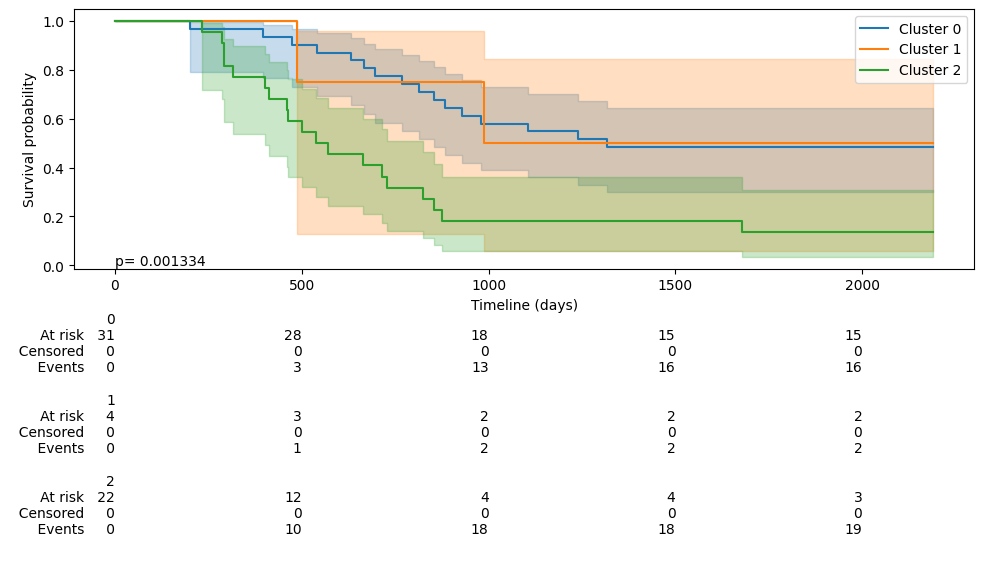

In [20]:
plt.figure(figsize=(10, 6)) 
ax = plt.subplot(111)
ax.text(0, 0, f"p= {round(logrank_test.p_value, 6)}")
clustering_statistical_table.loc["Overall Survival", "Deep clustering"] = logrank_test.p_value
kmfs = []
colors = ['y', 'm']
for cluster in sorted(clinical_data["clusters"].unique()):
    cli_clus = clinical_data[clinical_data["clusters"] == cluster]
    duration = cli_clus["label_days_to_death"]
    event = cli_clus["label_deceased"]
    kmf = KaplanMeierFitter().fit(duration, label = str(cluster), event_observed= event)
    kmfs.append(kmf)
    ax = kmf.plot(ax=ax)

add_at_risk_counts(*kmfs, ax=ax)
ax.set_ylabel("Survival probability")
ax.set_xlabel("Timeline (days)")
for i,cl in enumerate(ax.legend().get_texts()):
    cl.set_text(f'Cluster {i}')
plt.tight_layout()

In [271]:
cph = CoxPHFitter()
cph.fit(clinical_data[['Overall Survival (Months)', "clusters"]].replace({"clusters": 0}, 2).replace({"clusters": 1}, 0).replace({"clusters": 2}, 1), duration_col = 'Overall Survival (Months)').print_summary()
_ = cph.plot()

2024-05-29 12:25:25,712 - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-05-29 12:25:25,724 - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


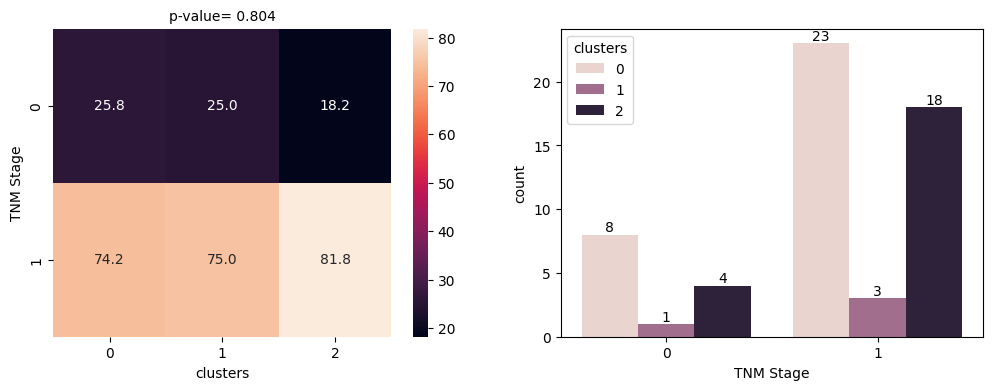

In [21]:
clinical_label = "clinical_TNM_Mixed_Stage_ord"
clinical_parameter = clinical_data[clinical_label]
clinical_label = "TNM Stage"
clinical_parameter = clinical_parameter.rename(clinical_label)
fig, axes = plt.subplots(1, 2, figsize= (12, 4))
crosstab = pd.crosstab(clinical_parameter, clinical_data['clusters'])
sns.heatmap(crosstab * 100 / crosstab.sum(0), annot=True, fmt=".1f", ax= axes[0])
pval = chi2_contingency(crosstab).pvalue
clustering_statistical_table.loc[clinical_label, "Deep clustering"] = pval
axes[0].set_title(f"p-value= {round(pval, 3)}", fontsize= 10)
clinical_parameter = clinical_parameter.to_frame()
clinical_parameter["clusters"] = clinical_data['clusters']
sns.countplot(data= clinical_parameter, x= clinical_label, hue= "clusters", ax= axes[1])
for container in axes[1].containers:
    axes[1].bar_label(container)

2024-05-29 12:25:29,589 - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-05-29 12:25:29,600 - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


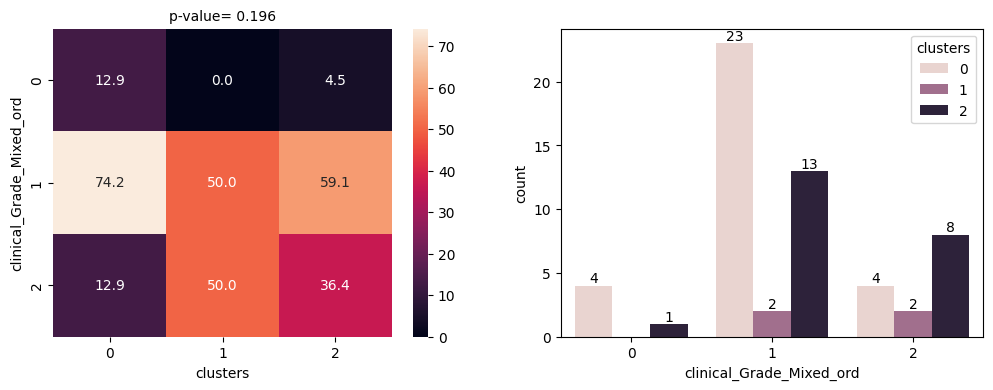

In [22]:
clinical_label = "clinical_Grade_Mixed_ord"
clinical_parameter = clinical_data[clinical_label]
fig, axes = plt.subplots(1, 2, figsize= (12, 4))
crosstab = pd.crosstab(clinical_parameter, clinical_data['clusters'])
sns.heatmap(crosstab * 100 / crosstab.sum(0), annot=True, fmt=".1f", ax= axes[0])
pval = chi2_contingency(pd.crosstab(clinical_parameter, clinical_data['clusters'])).pvalue
clustering_statistical_table.loc["Grade", "Deep clustering"] = pval
axes[0].set_title(f"p-value= {round(pval, 3)}", fontsize= 10)
clinical_parameter = clinical_parameter.to_frame()
clinical_parameter["clusters"] = clinical_data['clusters']
sns.countplot(data= clinical_parameter, x= clinical_label, hue= "clusters", ax= axes[1])
for container in axes[1].containers:
    axes[1].bar_label(container)

2024-05-29 12:25:32,408 - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-05-29 12:25:32,419 - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


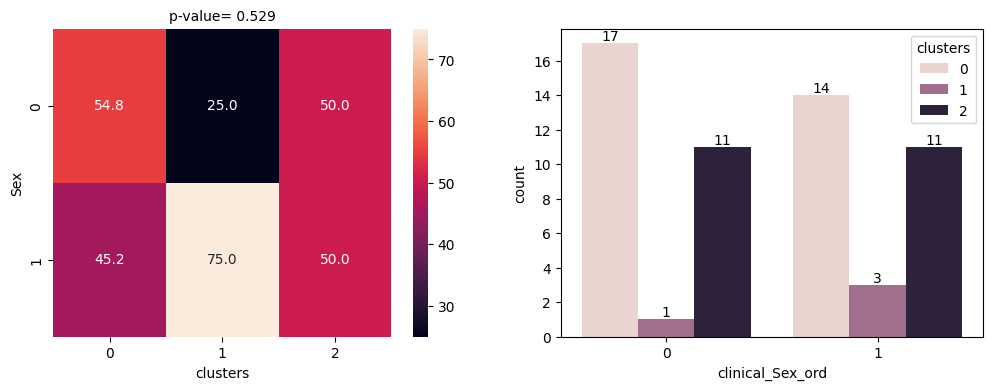

In [23]:
clinical_label = "clinical_Sex_ord"
clinical_parameter = clinical_data[clinical_label]
clinical_label = "Sex"
clinical_parameter = clinical_parameter.rename(clinical_label)
crosstab = pd.crosstab(clinical_parameter, clinical_data['clusters'])
fig, axes = plt.subplots(1, 2, figsize= (12, 4))
crosstab = pd.crosstab(clinical_parameter, clinical_data['clusters'])
sns.heatmap(crosstab * 100 / crosstab.sum(0), annot=True, fmt=".1f", ax= axes[0])
# clinical_parameter = crosstab
pval = chi2_contingency(crosstab).pvalue
clustering_statistical_table.loc[clinical_label, "Deep clustering"] = pval
axes[0].set_title(f"p-value= {round(pval, 3)}", fontsize= 10)
clinical_parameter = clinical_parameter.to_frame()
clinical_parameter["clusters"] = clinical_data['clusters']
sns.countplot(data= clinical_data, x= "clinical_Sex_ord", hue= "clusters", ax= axes[1])
for container in axes[1].containers:
    axes[1].bar_label(container)

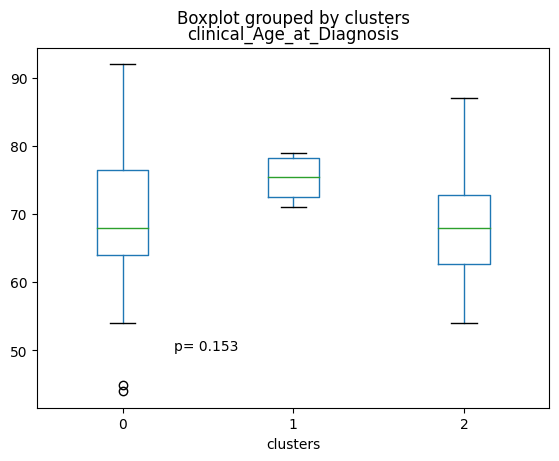

In [24]:
clinical_label = "clinical_Age_at_Diagnosis"
clinical_parameter = clinical_data[clinical_label]
pval = kruskal(*[clinical_parameter[clinical_data['clusters'] == cl] for cl in clinical_data['clusters'].unique()]).pvalue
clustering_statistical_table.loc["Diagnosis age", "Deep clustering"] = pval
clinical_parameter = clinical_parameter.to_frame()
clinical_parameter["clusters"] = clinical_data['clusters']
ax = clinical_parameter.boxplot(column= clinical_label, by= "clusters", grid=False)
_ = ax.text(1.3, 50, f"p= {round(pval, 3)}")

In [265]:
fig, axes = plt.subplots(1, 4, figsize= (25, 4))

ax = sns.violinplot(data= pd.DataFrame([methylation_data.loc[clinical_data[clinical_data["clusters"] == cl].index, transformed_Xs[1].columns].values.flatten() for cl in sorted(clinical_data["clusters"].unique())],
                                   index = [cl for cl in sorted(clinical_data["clusters"].unique())]).T,
                    orient= "h", ax = axes[0])
ax.set_title("All methylation values by cluster")

ax = sns.violinplot(data= pd.DataFrame([methylation_data.loc[clinical_data[clinical_data["clusters"] == cl].index, transformed_Xs[1].columns].mean(0) for cl in sorted(clinical_data["clusters"].unique())],
                                   index = [cl for cl in sorted(clinical_data["clusters"].unique())]).T,
                    orient= "h", ax = axes[1])
ax.set_title("Mean methylation values by cluster")

ax = sns.violinplot(data= pd.DataFrame([rnaseq_data.loc[clinical_data[clinical_data["clusters"] == cl].index, transformed_Xs[0].columns].apply(lambda x: np.log2(1 + x)).values.flatten() for cl in sorted(clinical_data["clusters"].unique())],
                                   index = [cl for cl in sorted(clinical_data["clusters"].unique())]).T,
                    orient= "h", ax = axes[2])
ax.set_title("All RNA-seq values by cluster")

ax = sns.violinplot(data= pd.DataFrame([rnaseq_data.loc[clinical_data[clinical_data["clusters"] == cl].index, transformed_Xs[0].columns].apply(lambda x: np.log2(1 + x)).mean(0) for cl in sorted(clinical_data["clusters"].unique())],
                                   index = [cl for cl in sorted(clinical_data["clusters"].unique())]).T,
                    orient= "h", ax = axes[3])
= ax.set_title("Mean RNA-seq values by cluster")

In [25]:
transformed_X = pd.concat(transformed_Xs, axis = 1)
print("transformed_X.shape", transformed_X.shape)
transformed_X.head()

transformed_X.shape (57, 4079)


,pathology_NF40_25%,pathology_NF39_0.01,pathology_NF62_75%,pathology_NF58_0.01,pathology_NF46_0.1,pathology_NF16_0.95,pathology_NF59_min,pathology_NF22_std,pathology_NF37_75%,pathology_NF20_0.05,...,rna_expr_NISCH,rna_expr_MFN2,rna_expr_RNF103,rna_expr_KCNK1,rna_expr_VASH1,rna_expr_TBC1D4,rna_expr_EPS15L1,rna_expr_MANBA,rna_expr_ZNF561,rna_expr_CHD8
GI-19-025,0.367328,-0.810757,-0.552298,2.159154,-0.392823,0.441931,-0.184171,-0.591346,-0.440044,-0.408607,...,2.049733,0.474814,0.043321,0.471066,1.272184,0.488833,0.637678,-1.155892,0.736838,-0.601676
GI-17-537,-0.303663,0.272336,0.152459,-0.593308,-1.758790,-0.249435,-0.114272,0.677331,0.038939,-1.280577,...,0.006706,0.034058,-0.788790,0.856090,-1.495812,-1.646213,-1.959113,0.465773,-1.680937,-0.149380
GI-19-002,-0.877454,0.585332,-0.474427,0.721843,-0.572134,-0.559015,0.113210,-1.013564,0.055880,-0.443388,...,0.725072,-1.426800,2.518113,2.680890,-0.038420,1.299193,0.560943,-0.087747,0.902409,-0.214801
GI-16-575,-0.830592,0.464602,-0.342237,-0.390973,-1.088246,-0.776971,-0.538961,-0.395434,0.036546,-0.502933,...,0.714849,0.209502,2.496975,1.802813,0.787575,2.618538,0.563724,0.076825,0.845196,-0.558754
GI-14-974,1.035411,-0.506171,5.938190,1.738033,-1.251690,1.770552,5.379658,-1.887434,-2.924526,-0.176278,...,0.082546,1.831900,0.328788,-0.865642,-0.148522,0.094332,2.463851,-2.155652,0.964566,0.365523


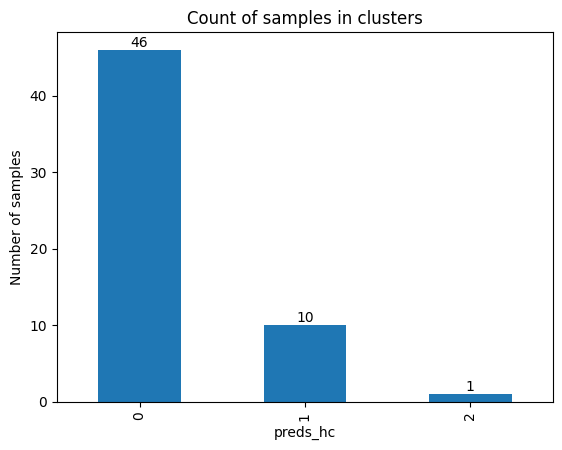

In [56]:
from sklearn.cluster import AgglomerativeClustering

preds_hc = AgglomerativeClustering(n_clusters= int(best_trial["params_n_clusters"])).fit_predict(transformed_X)
clinical_data["preds_hc"] = preds_hc
ax = clinical_data["preds_hc"].value_counts().plot(kind="bar", title= "Count of samples in clusters", x= "preds_hc", ylabel= "Number of samples")
for container in ax.containers:
    ax.bar_label(container)

In [57]:
removing_outliers = pd.Series(preds_hc).value_counts()
removing_outliers = removing_outliers.index[removing_outliers > 1]
removing_outliers = clinical_data["preds_hc"].isin(removing_outliers)

In [58]:
logrank_test = multivariate_logrank_test(event_durations= clinical_data.loc[removing_outliers, "label_days_to_death"], groups= clinical_data.loc[removing_outliers, "preds_hc"], event_observed=clinical_data.loc[removing_outliers, "label_deceased"])
logrank_test

<lifelines.StatisticalResult: multivariate_logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = multivariate_logrank_test

---
 test_statistic    p  -log2(p)
           0.53 0.47      1.10

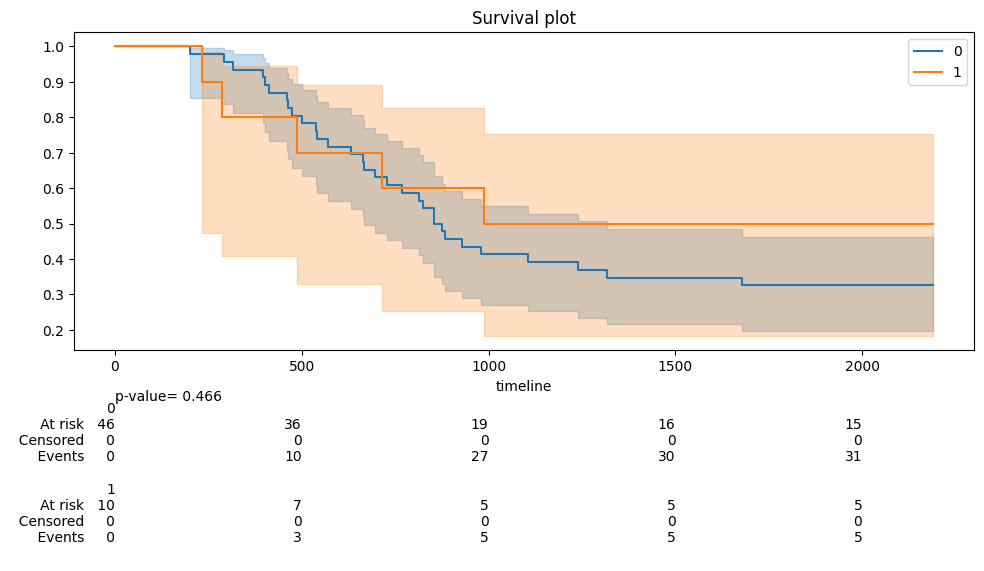

In [59]:
plt.figure(figsize=(10, 6)) 
ax = plt.subplot(111)
ax.set_title("Survival plot")
ax.text(0, 0, f"p-value= {round(logrank_test.p_value, 3)}")
clustering_statistical_table.loc["Overall Survival", "HC"] = logrank_test.p_value
kmfs = []
for cluster in sorted(clinical_data.loc[removing_outliers, "preds_hc"].unique()):
    cli_clus = clinical_data[clinical_data["preds_hc"] == cluster]
    duration = cli_clus["label_days_to_death"]
    event = cli_clus["label_deceased"]
    kmf = KaplanMeierFitter().fit(duration, label = str(cluster), event_observed= event)
    kmfs.append(kmf)
    ax = kmf.plot(ax=ax)

add_at_risk_counts(*kmfs, ax=ax)
plt.tight_layout()

2024-05-29 12:36:26,607 - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-05-29 12:36:26,616 - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


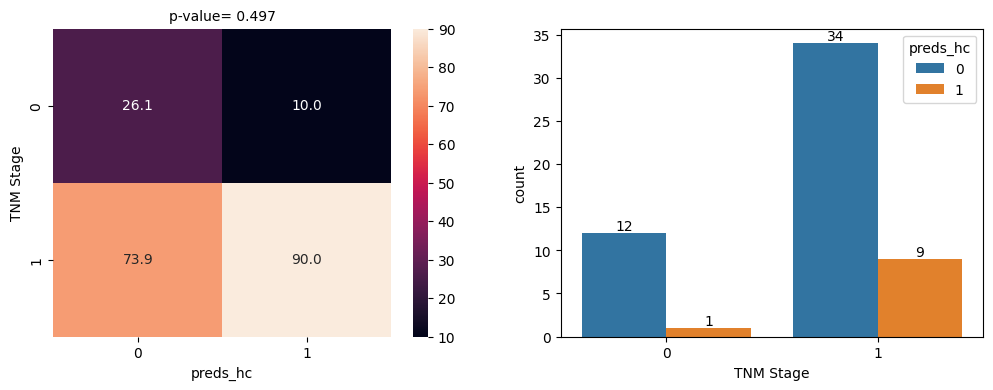

In [60]:
clinical_label = "clinical_TNM_Mixed_Stage_ord"
clinical_parameter = clinical_data.loc[removing_outliers, clinical_label]
clinical_label = "TNM Stage"
clinical_parameter = clinical_parameter.rename(clinical_label)
fig, axes = plt.subplots(1, 2, figsize= (12, 4))
crosstab = pd.crosstab(clinical_parameter, clinical_data.loc[removing_outliers, 'preds_hc'])
sns.heatmap(crosstab * 100 / crosstab.sum(0), annot=True, fmt=".1f", ax= axes[0])
pval = chi2_contingency(crosstab).pvalue
clustering_statistical_table.loc[clinical_label, "HC"] = pval
axes[0].set_title(f"p-value= {round(pval, 3)}", fontsize= 10)
clinical_parameter = clinical_parameter.to_frame()
clinical_parameter["preds_hc"] = clinical_data.loc[removing_outliers, 'preds_hc']
sns.countplot(data= clinical_parameter, x= clinical_label, hue= "preds_hc", ax= axes[1])
for container in axes[1].containers:
    axes[1].bar_label(container)

2024-05-29 12:36:28,431 - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-05-29 12:36:28,440 - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


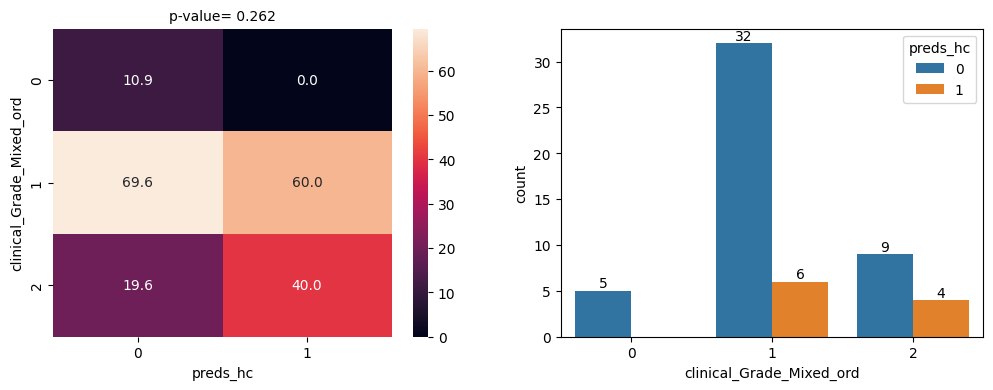

In [61]:
clinical_label = "clinical_Grade_Mixed_ord"
clinical_parameter = clinical_data.loc[removing_outliers, clinical_label]
fig, axes = plt.subplots(1, 2, figsize= (12, 4))
crosstab = pd.crosstab(clinical_parameter, clinical_data.loc[removing_outliers, 'preds_hc'])
sns.heatmap(crosstab * 100 / crosstab.sum(0), annot=True, fmt=".1f", ax= axes[0])
pval = chi2_contingency(pd.crosstab(clinical_parameter, clinical_data.loc[removing_outliers, 'preds_hc'])).pvalue
clustering_statistical_table.loc["Grade", "HC"] = pval
axes[0].set_title(f"p-value= {round(pval, 3)}", fontsize= 10)
clinical_parameter = clinical_parameter.to_frame()
clinical_parameter["preds_hc"] = clinical_data.loc[removing_outliers, 'preds_hc']
sns.countplot(data= clinical_parameter, x= clinical_label, hue= "preds_hc", ax= axes[1])
for container in axes[1].containers:
    axes[1].bar_label(container)

2024-05-29 12:36:59,187 - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-05-29 12:36:59,198 - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


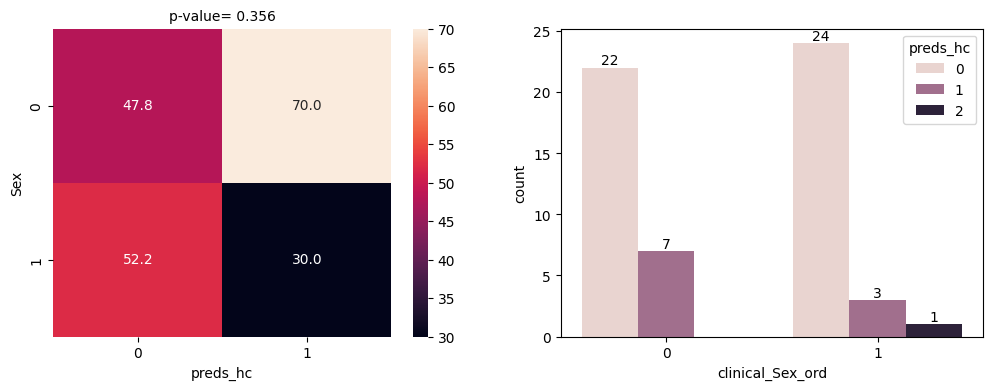

In [64]:
clinical_label = "clinical_Sex_ord"
clinical_parameter = clinical_data.loc[removing_outliers, clinical_label]
clinical_label = "Sex"
clinical_parameter = clinical_parameter.rename(clinical_label)
crosstab = pd.crosstab(clinical_parameter, clinical_data.loc[removing_outliers, 'preds_hc'])
fig, axes = plt.subplots(1, 2, figsize= (12, 4))
crosstab = pd.crosstab(clinical_parameter, clinical_data.loc[removing_outliers, 'preds_hc'])
sns.heatmap(crosstab * 100 / crosstab.sum(0), annot=True, fmt=".1f", ax= axes[0])
# clinical_parameter = crosstab
pval = chi2_contingency(crosstab).pvalue
clustering_statistical_table.loc[clinical_label, "HC"] = pval
axes[0].set_title(f"p-value= {round(pval, 3)}", fontsize= 10)
clinical_parameter = clinical_parameter.to_frame()
clinical_parameter["preds_hc"] = clinical_data.loc[removing_outliers, 'preds_hc']
sns.countplot(data= clinical_data, x= "clinical_Sex_ord", hue= "preds_hc", ax= axes[1])
for container in axes[1].containers:
    axes[1].bar_label(container)

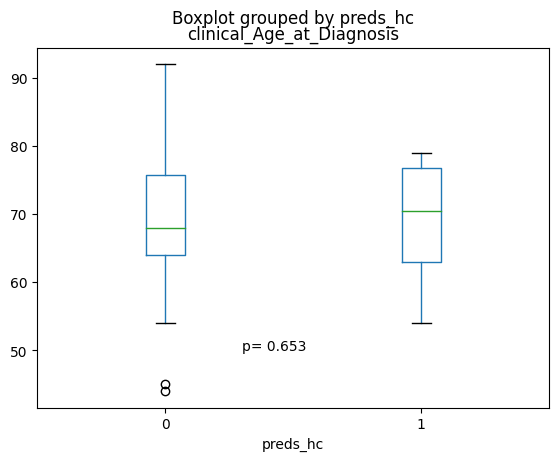

In [65]:
clinical_label = "clinical_Age_at_Diagnosis"
clinical_parameter = clinical_data.loc[removing_outliers, clinical_label]
pval = kruskal(*[clinical_parameter[clinical_data.loc[removing_outliers, 'preds_hc'] == cl] for cl in clinical_data.loc[removing_outliers, 'preds_hc'].unique()]).pvalue
clustering_statistical_table.loc["Diagnosis age", "HC"] = pval
clinical_parameter = clinical_parameter.to_frame()
clinical_parameter["preds_hc"] = clinical_data.loc[removing_outliers, 'preds_hc']
ax = clinical_parameter.boxplot(column= clinical_label, by= "preds_hc", grid=False)
_ = ax.text(1.3, 50, f"p= {round(pval, 3)}")

/home/alberto/anaconda3/envs/edc_mo_pdac_val/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


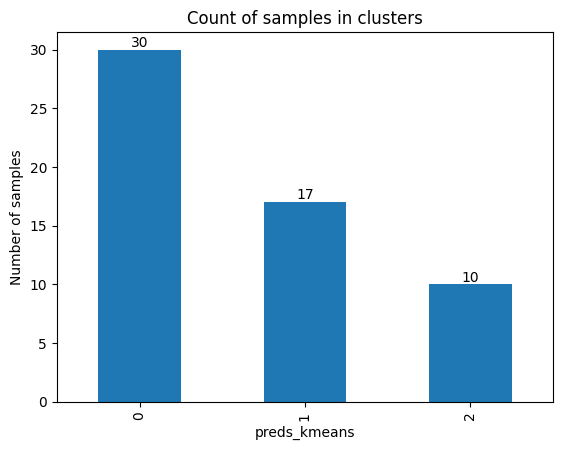

In [34]:
from sklearn.cluster import KMeans

preds_kmeans = KMeans(n_clusters= int(best_trial["params_n_clusters"]), random_state= 42).fit_predict(transformed_X)
clinical_data["preds_kmeans"] = preds_kmeans
ax = clinical_data["preds_kmeans"].value_counts().plot(kind="bar", title= "Count of samples in clusters", x= "preds_kmeans", ylabel= "Number of samples")
for container in ax.containers:
    ax.bar_label(container)

In [35]:
logrank_test = multivariate_logrank_test(event_durations= clinical_data["label_days_to_death"], groups= clinical_data["preds_kmeans"], event_observed=clinical_data["label_deceased"])
logrank_test

<lifelines.StatisticalResult: multivariate_logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 2
         test_name = multivariate_logrank_test

---
 test_statistic    p  -log2(p)
           1.30 0.52      0.94

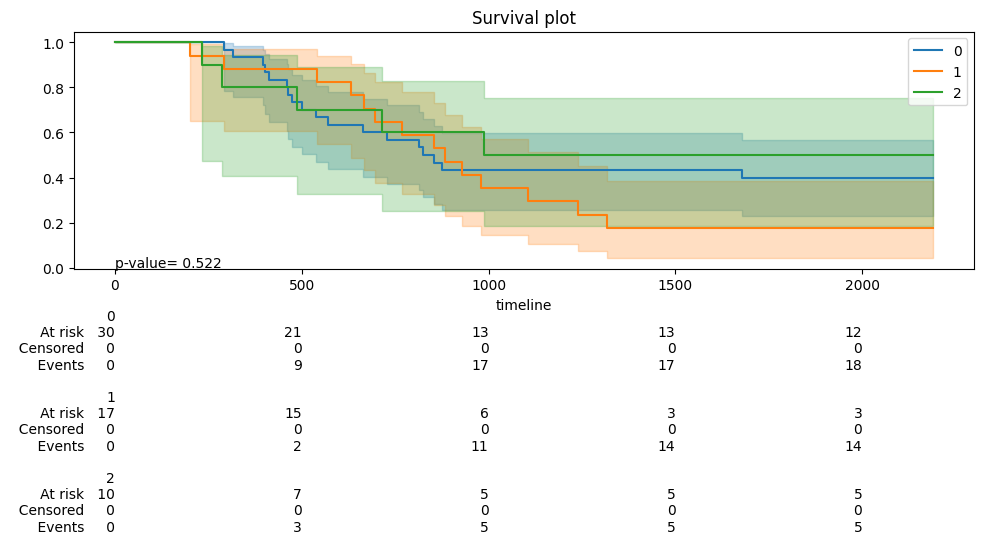

In [36]:
plt.figure(figsize=(10, 6)) 
ax = plt.subplot(111)
ax.set_title("Survival plot")
ax.text(0, 0, f"p-value= {round(logrank_test.p_value, 3)}")
clustering_statistical_table.loc["Overall Survival", "K-Means"] = logrank_test.p_value
kmfs = []
for cluster in sorted(clinical_data["preds_kmeans"].unique()):
    cli_clus = clinical_data[clinical_data["preds_kmeans"] == cluster]
    duration = cli_clus["label_days_to_death"]
    event = cli_clus["label_deceased"]
    kmf = KaplanMeierFitter().fit(duration, label = str(cluster), event_observed= event)
    kmfs.append(kmf)
    ax = kmf.plot(ax=ax)

add_at_risk_counts(*kmfs, ax=ax)
plt.tight_layout()

2024-05-29 12:26:50,911 - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-05-29 12:26:50,920 - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


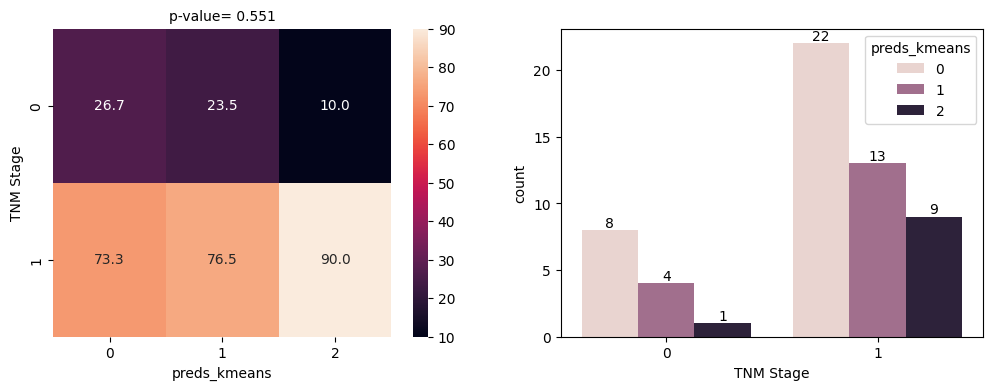

In [37]:
clinical_label = "clinical_TNM_Mixed_Stage_ord"
clinical_parameter = clinical_data[clinical_label]
clinical_label = "TNM Stage"
clinical_parameter = clinical_parameter.rename(clinical_label)
fig, axes = plt.subplots(1, 2, figsize= (12, 4))
crosstab = pd.crosstab(clinical_parameter, clinical_data['preds_kmeans'])
sns.heatmap(crosstab * 100 / crosstab.sum(0), annot=True, fmt=".1f", ax= axes[0])
pval = chi2_contingency(crosstab).pvalue
clustering_statistical_table.loc[clinical_label, "K-Means"] = pval
axes[0].set_title(f"p-value= {round(pval, 3)}", fontsize= 10)
clinical_parameter = clinical_parameter.to_frame()
clinical_parameter["preds_kmeans"] = clinical_data['preds_kmeans']
sns.countplot(data= clinical_parameter, x= clinical_label, hue= "preds_kmeans", ax= axes[1])
for container in axes[1].containers:
    axes[1].bar_label(container)

2024-05-29 12:26:52,314 - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-05-29 12:26:52,323 - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


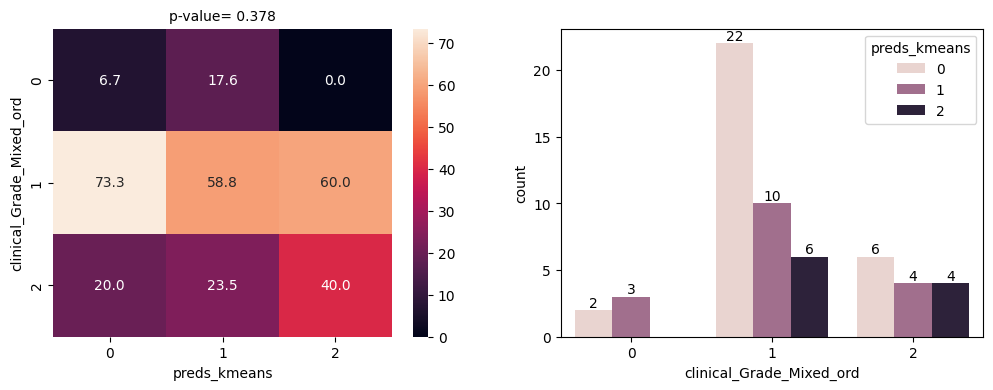

In [38]:
clinical_label = "clinical_Grade_Mixed_ord"
clinical_parameter = clinical_data[clinical_label]
fig, axes = plt.subplots(1, 2, figsize= (12, 4))
crosstab = pd.crosstab(clinical_parameter, clinical_data['preds_kmeans'])
sns.heatmap(crosstab * 100 / crosstab.sum(0), annot=True, fmt=".1f", ax= axes[0])
pval = chi2_contingency(pd.crosstab(clinical_parameter, clinical_data['preds_kmeans'])).pvalue
clustering_statistical_table.loc["Grade", "K-Means"] = pval
axes[0].set_title(f"p-value= {round(pval, 3)}", fontsize= 10)
clinical_parameter = clinical_parameter.to_frame()
clinical_parameter["preds_kmeans"] = clinical_data['preds_kmeans']
sns.countplot(data= clinical_parameter, x= clinical_label, hue= "preds_kmeans", ax= axes[1])
for container in axes[1].containers:
    axes[1].bar_label(container)

2024-05-29 12:26:59,099 - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-05-29 12:26:59,110 - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


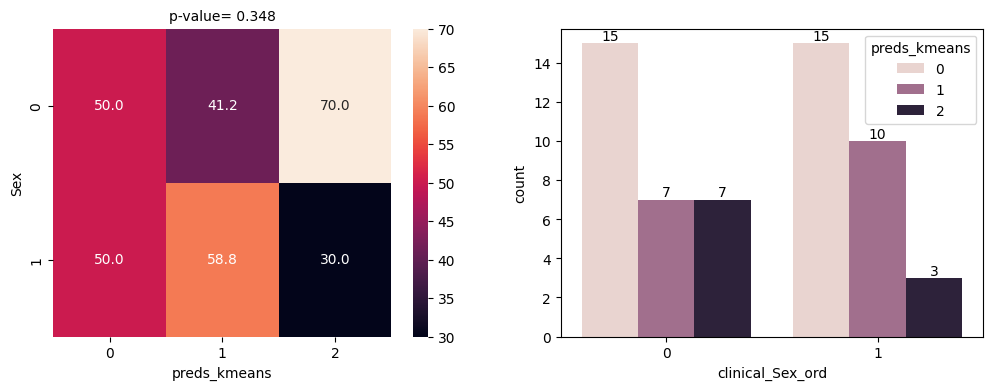

In [39]:
clinical_label = "clinical_Sex_ord"
clinical_parameter = clinical_data[clinical_label]
clinical_label = "Sex"
clinical_parameter = clinical_parameter.rename(clinical_label)
crosstab = pd.crosstab(clinical_parameter, clinical_data['preds_kmeans'])
fig, axes = plt.subplots(1, 2, figsize= (12, 4))
crosstab = pd.crosstab(clinical_parameter, clinical_data['preds_kmeans'])
sns.heatmap(crosstab * 100 / crosstab.sum(0), annot=True, fmt=".1f", ax= axes[0])
# clinical_parameter = crosstab
pval = chi2_contingency(crosstab).pvalue
clustering_statistical_table.loc[clinical_label, "K-Means"] = pval
axes[0].set_title(f"p-value= {round(pval, 3)}", fontsize= 10)
clinical_parameter = clinical_parameter.to_frame()
clinical_parameter["preds_kmeans"] = clinical_data['preds_kmeans']
sns.countplot(data= clinical_data, x= "clinical_Sex_ord", hue= "preds_kmeans", ax= axes[1])
for container in axes[1].containers:
    axes[1].bar_label(container)

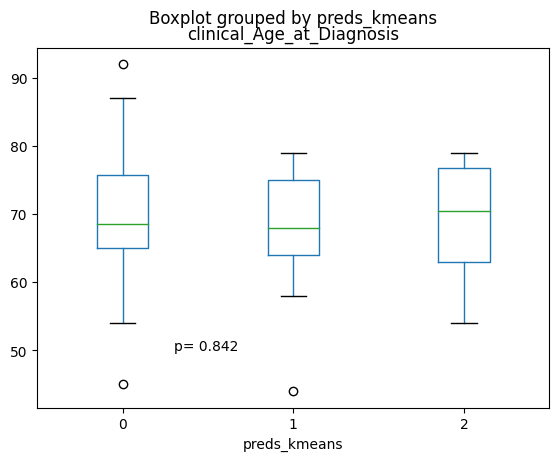

In [40]:
clinical_label = "clinical_Age_at_Diagnosis"
clinical_parameter = clinical_data[clinical_label]
pval = kruskal(*[clinical_parameter[clinical_data['preds_kmeans'] == cl] for cl in clinical_data['preds_kmeans'].unique()]).pvalue
clustering_statistical_table.loc["Diagnosis age", "K-Means"] = pval
clinical_parameter = clinical_parameter.to_frame()
clinical_parameter["preds_kmeans"] = clinical_data['preds_kmeans']
ax = clinical_parameter.boxplot(column= clinical_label, by= "preds_kmeans", grid=False)
_ = ax.text(1.3, 50, f"p= {round(pval, 3)}")

In [66]:
print(clustering_statistical_table.to_latex(float_format="{:.3f}".format))

\begin{tabular}{llll}
\toprule
 & Deep clustering & K-Means & HC \\
\midrule
Overall Survival & 0.001 & 0.522 & 0.466 \\
Diagnosis age & 0.153 & 0.842 & 0.653 \\
TNM Stage & 0.804 & 0.551 & 0.497 \\
Grade & 0.196 & 0.378 & 0.262 \\
Sex & 0.529 & 0.348 & 0.356 \\
\bottomrule
\end{tabular}



In [67]:
print(clustering_statistical_table.to_latex(float_format="{:.1e}".format))

\begin{tabular}{llll}
\toprule
 & Deep clustering & K-Means & HC \\
\midrule
Overall Survival & 1.3e-03 & 5.2e-01 & 4.7e-01 \\
Diagnosis age & 1.5e-01 & 8.4e-01 & 6.5e-01 \\
TNM Stage & 8.0e-01 & 5.5e-01 & 5.0e-01 \\
Grade & 2.0e-01 & 3.8e-01 & 2.6e-01 \\
Sex & 5.3e-01 & 3.5e-01 & 3.6e-01 \\
\bottomrule
\end{tabular}



In [68]:
from IPython.display import display, HTML

display(HTML(clustering_statistical_table.to_html()))

,Deep clustering,K-Means,HC
Overall Survival,0.001334,0.521535,0.466158
Diagnosis age,0.153484,0.84192,0.652903
TNM Stage,0.803858,0.551417,0.49724
Grade,0.19629,0.378234,0.262461
Sex,0.529096,0.347754,0.356158


In [23]:
method = make_pipeline(StandardScaler(), PCA(n_components = 2, random_state = settings.RANDOM_STATE))
plot_data = method.fit_transform(z_full)
fig = px.scatter(x = plot_data[:, 0], y = plot_data[:, 1], color = clinical_data["clusters"].astype(str))
fig.show()

In [24]:
method = make_pipeline(StandardScaler(), PCA(n_components = 2, random_state = settings.RANDOM_STATE))
plot_data = method.fit_transform(z_full)
fig = px.scatter(x = plot_data[:, 0], y = plot_data[:, 1], color = clinical_data["Overall Survival (Months)"], color_continuous_scale=px.colors.sequential.Bluered)
fig.show()

In [25]:
method = make_pipeline(StandardScaler(), PCA(n_components = 3, random_state = settings.RANDOM_STATE))
plot_data = method.fit_transform(z_full)
fig = px.scatter_3d(x = plot_data[:, 0], y = plot_data[:, 1], z = plot_data[:, 2], color = clusters.astype(str))
fig.show()

In [26]:
method = make_pipeline(StandardScaler(), PCA(n_components = 3, random_state = settings.RANDOM_STATE))
plot_data = method.fit_transform(z_full)
fig = px.scatter_3d(x = plot_data[:, 0], y = plot_data[:, 1], z = plot_data[:, 2], color = clinical_data["Overall Survival (Months)"],
                    color_continuous_scale=px.colors.sequential.Bluered)
fig.show()

In [27]:
method = PCA(n_components = 2, random_state = settings.RANDOM_STATE)
plot_data = method.fit_transform(transformed_X)
fig = px.scatter(x = plot_data[:, 0], y = plot_data[:, 1], 
                 color = make_pipeline(StandardScaler(), KMeans(n_clusters=optimization_study.best_params["n_clusters"], random_state = settings.RANDOM_STATE)).fit_predict(plot_data).astype(str))
fig.show()

In [28]:
method = PCA(n_components = 2, random_state = settings.RANDOM_STATE)
plot_data = method.fit_transform(transformed_X)
fig = px.scatter(x = plot_data[:, 0], y = plot_data[:, 1], color = clinical_data["Overall Survival (Months)"], color_continuous_scale=px.colors.sequential.Bluered)
fig.show()

In [29]:
method = TSNE(n_components = 2, random_state = settings.RANDOM_STATE)
plot_data = method.fit_transform(transformed_X)
fig = px.scatter(x = plot_data[:, 0], y = plot_data[:, 1],
                 color = make_pipeline(StandardScaler(), KMeans(n_clusters=optimization_study.best_params["n_clusters"], random_state = settings.RANDOM_STATE)).fit_predict(plot_data).astype(str))
fig.show()

In [30]:
method = TSNE(n_components = 2, random_state = settings.RANDOM_STATE)
plot_data = method.fit_transform(transformed_X)
fig = px.scatter(x = plot_data[:, 0], y = plot_data[:, 1], color = clinical_data["Overall Survival (Months)"], color_continuous_scale=px.colors.sequential.Bluered)
fig.show()

In [31]:
method = UMAP(n_components = 2, random_state = settings.RANDOM_STATE)
plot_data = method.fit_transform(transformed_X)
fig = px.scatter(x = plot_data[:, 0], y = plot_data[:, 1],
                 color = make_pipeline(StandardScaler(), KMeans(n_clusters=optimization_study.best_params["n_clusters"], random_state = settings.RANDOM_STATE)).fit_predict(plot_data).astype(str))
fig.show()

In [32]:
method = UMAP(n_components = 2, random_state = settings.RANDOM_STATE)
plot_data = method.fit_transform(transformed_X)
fig = px.scatter(x = plot_data[:, 0], y = plot_data[:, 1], color = clinical_data["Overall Survival (Months)"], color_continuous_scale=px.colors.sequential.Bluered)
fig.show()

In [33]:
method = PCA(n_components = 3, random_state = settings.RANDOM_STATE)
plot_data = method.fit_transform(transformed_X)
fig = px.scatter_3d(x = plot_data[:, 0], y = plot_data[:, 1], z = plot_data[:, 2],
                    color = make_pipeline(StandardScaler(), KMeans(n_clusters=optimization_study.best_params["n_clusters"], random_state = settings.RANDOM_STATE)).fit_predict(plot_data).astype(str))
fig.show()

In [34]:
method = PCA(n_components = 3, random_state = settings.RANDOM_STATE)
plot_data = method.fit_transform(transformed_X)
fig = px.scatter_3d(x = plot_data[:, 0], y = plot_data[:, 1], z = plot_data[:, 2], color = clinical_data["Overall Survival (Months)"], 
                    color_continuous_scale=px.colors.sequential.Bluered)
fig.show()

In [35]:
method = TSNE(n_components = 3, random_state = settings.RANDOM_STATE)
plot_data = method.fit_transform(transformed_X)
fig = px.scatter_3d(x = plot_data[:, 0], y = plot_data[:, 1], z = plot_data[:, 2],
                    color = make_pipeline(StandardScaler(), KMeans(n_clusters=optimization_study.best_params["n_clusters"], random_state = settings.RANDOM_STATE)).fit_predict(plot_data).astype(str))
fig.show()

In [36]:
method = TSNE(n_components = 3, random_state = settings.RANDOM_STATE)
plot_data = method.fit_transform(transformed_X)
fig = px.scatter_3d(x = plot_data[:, 0], y = plot_data[:, 1], z = plot_data[:, 2], color = clinical_data["Overall Survival (Months)"], 
                    color_continuous_scale=px.colors.sequential.Bluered)
fig.show()

In [37]:
method = UMAP(n_components = 3, random_state = settings.RANDOM_STATE)
plot_data = method.fit_transform(transformed_X)
fig = px.scatter_3d(x = plot_data[:, 0], y = plot_data[:, 1], z = plot_data[:, 2],
                    color = make_pipeline(StandardScaler(), KMeans(n_clusters=optimization_study.best_params["n_clusters"], random_state = settings.RANDOM_STATE)).fit_predict(plot_data).astype(str))
fig.show()

In [38]:
method = UMAP(n_components = 3, random_state = settings.RANDOM_STATE)
plot_data = method.fit_transform(transformed_X)
fig = px.scatter_3d(x = plot_data[:, 0], y = plot_data[:, 1], z = plot_data[:, 2], color = clinical_data["Overall Survival (Months)"],
                    color_continuous_scale=px.colors.sequential.Bluered)
fig.show()